<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h1>Should This Loan be Approved or Denied ?</h1>

An XGBoost data model to predict whether a loan can be approved or denied.<br><br>
    
Any comments are welcome.
    
The Notebook is divided into 2 Parts:
- <b>Part 1 :</b> Pipeline - this is the end result encapsulated into a pipeline<br><br>
- <b>Part 2 :</b> Data Exploration (EDA) and Preparation, Modeling, Metrics - from start to end, with some notes to make sense of it<br><br>
     "Our model results are way more dependent on how well feature engineering is performed than on the model itself. Machine Learning models are like very skilled linguists that can decipher any text in any language. However, it will not be helpful if they are handed a bunch of scribbles or blurred out text. EDA should not be skipped, as a thorough EDA and feature engineering process accounts for 90% of the results of a good model."
</div>

**Dataset Source**

https://www.kaggle.com/mirbektoktogaraev/should-this-loan-be-approved-or-denied

In [291]:
#filepath = "../input/should-this-loan-be-approved-or-denied/"  # Kaggle
#savepath = "./"   #Kaggle

filepath = "C:\\Python\\Python_Data_Science_Exercises\\datasets\\"
savepath = "C:\\Python\\Python_Data_Science_Exercises\\datasets\\"

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Tools</b></div>

In [292]:
piplist = !pip list

# for text-to-speech
if not piplist.grep('pyttsx3'):
    !pip install pyttsx3
    
# for oversampling
if not piplist.grep('imbalanced-learn'):
    !pip install imbalanced-learn

In [293]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pyttsx3
from IPython.display import FileLink
import hashlib
%matplotlib inline

In [294]:
''' 
Set up voice object.  Used in different areas of notebook to indicate completion of long processes.
'''
if savepath != "./":   # not Kaggle
    engine = pyttsx3.init()  # object creation

    """ RATE"""
    rate = engine.getProperty('rate')   # getting details of current speaking rate
    #print (rate)                        #printing current voice rate
    engine.setProperty('rate', 175)     # setting up new voice rate

    """VOLUME"""
    volume = engine.getProperty('volume')   #getting to know current volume level (min=0 and max=1)
    #print (volume)                         #printing current volume level
    engine.setProperty('volume',0.7)        # setting up volume level  between 0 and 1

    """VOICE"""
    voices = engine.getProperty('voices')       #getting details of current voice
    #engine.setProperty('voice', voices[0].id)  #changing index, changes voices. o for male
    engine.setProperty('voice', voices[1].id)   #changing index, changes voices. 1 for female

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Custom Functions and Classes</b></div>

In [297]:
class color:
   purple = '\033[95m'
   cyan = '\033[96m'
   darkcyan = '\033[36m'
   blue = '\033[94m'
   green = '\033[92m'
   yellow = '\033[93m'
   red = '\033[91m'
   bold = '\033[1m'
   underline = '\033[4m'
   end = '\033[0m'

In [295]:
def check_cols_with_nulls(df):
    cols_with_missing = [col for col in df.columns if df[col].isnull().any()]
    if len(cols_with_missing) == 0:
        print("No Missing Values")
    else:
        print(cols_with_missing)
    
    sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [296]:
def check_infinity_nan(df,dfname):
    print("checking for infinity")
  
    #ds = sba.isin([np.inf, -np.inf])
    #print(ds)
  
    # printing the count of infinity values
    print()
    print("printing the count of infinity values")
  
    count = np.isinf(df).values.sum()
    print(f"{dfname} contains " + str(count) + " infinite values")
    print()
    
    has_nan = df.isnull().values.any()
    print(f"Does {dfname} have Nan or Null values ?  {has_nan}")

In [298]:
# used as a converter when loading csv
def fixvals(val):
    retval = val.replace('$','').replace(',','')
    return retval

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Metrics Function</b></div>

In [299]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix

def model_eval(y_valid,predictions):
    print('MAE:', metrics.mean_absolute_error(y_valid, predictions))
    print('MSE:', metrics.mean_squared_error(y_valid, predictions))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, predictions)))
    print()
    
    print("Classification Report:")
    print(classification_report(y_valid,predictions.round()))
    print()
    
    print(color.bold + "Accuracy for model: %.2f" % (accuracy_score(y_valid, \
                                                            predictions.round()) * 100) + color.end)

**Feature Importance**

In [300]:
from xgboost import plot_importance

# Plot feature importance
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize,dpi=600)
    return plot_importance(booster=booster, ax=ax)

**Mutual Information**

In [301]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    print()
    print("Please wait, Mutual Information gathering can take time (about 30 mins) ...")
    X = X.copy()
    #for colname in X.select_dtypes(["object", "category"]):
    #    X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    #discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    #mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = mutual_info_regression(X, y, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    print("Mutual Information gathering done ...")
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Machine Learning Class</b></div>

In [302]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from xgboost import XGBClassifier

class process_model():  
    def __init__(self, X, y):
        self.X = X
        self.y = y

        print('MIS_Status Count : ',Counter(y))
    
    # oversampling method
    def osample(self):
        # define oversampling strategy
        oversample = RandomOverSampler(sampling_strategy='minority') 
        print(len(self.X))
        print(len(self.y))
        # fit and apply the transform
        X_over, y_over = oversample.fit_resample(self.X, self.y)

        # summarize class distribution
        print('Before Oversampling : ',Counter(self.y))
        print('After Oversampling  : ',Counter(y_over))
        
        # update X and y with the oversampled results 
        self.X = X_over
        self.y = y_over
        
        # return the oversampled results in case they are needed in another module
        return {'X_over':X_over, 'y_over':y_over}
    
    # Method to run model 
    # X_size - size of X - e.g. 0.8
    # desc - description of metrics report
    def prep_run_model(self, X_size, desc='Metrics', mn_estimators=1000, mlearning_rate=0.05,\
                      mmax_depth=6):
        self.X_size = X_size
        self.desc = desc
        self.mn_estimators = mn_estimators
        self.mlearning_rate = mlearning_rate
        self.mmax_depth = mmax_depth
        
        # Split Data into Train:Validate:Test
        
        # train_size=X_size

        # In the first step, we will split the data in training and remaining dataset
        X_train, X_rem, y_train, y_rem = train_test_split(self.X, self.y, train_size=self.X_size,\
                                                        random_state=101) 

        # Now since we want the valid and test size to be equal. 
        # we have to define valid_size=0.5 (that is 50% of remaining data)
        # test_size = 0.5

        X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem,test_size=0.5,\
                                                            random_state=101)
    
        print()
        print(color.bold + color.underline + "Shapes Before And After Splitting Dataset :" +\
              color.end)
        print('X',X.shape,end=''), print('   y', y.shape)
        print('X_train',X_train.shape,end=''), print('   y_train', y_train.shape)
        print('X_valid',X_valid.shape,end=''), print('   y_valid', y_valid.shape)
        print('X_test', X_test.shape, end=''), print('   y_test', y_test.shape)
    
        print()
        print(color.bold + "Please wait, Fitting model can take time ..." + color.end)
        
        '''
        XGBRegressor is for continuous target/outcome variables. These are often called "regression 
        problems."

        XGBClassifier is for categorical target/outcome variables. These are often called 
        "classification problems."
        
        xg_model = XGBRegressor(n_estimators = self.mn_estimators, \
                                learning_rate = self.mlearning_rate, \
                                max_depth = self.mmax_depth,\
                                n_jobs=4)
        '''
        xg_model = XGBClassifier(n_estimators = self.mn_estimators, \
                                learning_rate = self.mlearning_rate, \
                                max_depth = self.mmax_depth,\
                                use_label_encoder =False,\
                                n_jobs=4)
       
        xg_model.fit(X_train, y_train, 
                     early_stopping_rounds=5,
                     eval_metric=['logloss'],
                     eval_set=[(X_valid, y_valid)], 
                     verbose=False)
 
        print("Fitting model completed.")
    
        # Get predictions
        predictions = xg_model.predict(X_valid)
    
    
        print()
        print(color.underline + self.desc + color.end)
        model_eval(y_valid, predictions)
        
        # Return these values as they will be needed for further testing or metrics
        # in dictionary form to remember easier 
        return {'xg_model':xg_model,'predictions':predictions, \
                    'X_train':X_train, 'y_train':y_train, \
                    'X_valid':X_valid, 'y_valid':y_valid, \
                    'X_test':X_test, 'y_test':y_test}

<div style="font-family: Trebuchet MS;background-color:DarkRed;color:AliceBlue;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
<h3>Part 1. Pipeline</h3></div>

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
<h3>1. Load File for Pipeline</h3></div>

In [303]:
sba = pd.read_csv(filepath + 'SBAnational.csv',\
                 converters = {'DisbursementGross':fixvals,'SBA_Appv':fixvals,\
                              'GrAppv':fixvals, 'ChgOffPrinGr':fixvals}, \
                              parse_dates=['DisbursementDate'], low_memory=False)
print("Shape of original SBA dataset : ", sba.shape)
print()
print(sba[['DisbursementGross','SBA_Appv','GrAppv','ChgOffPrinGr','DisbursementDate']].head(2))

# Filter data to before 2011
sba = sba[sba['DisbursementDate'] <= '2010-12-31']
print()
print(f"Size of data after 2010-12-31 : \
    {len(sba[sba['DisbursementDate'] > '2010-12-31'])}")
print()
print(f"Size of data before 2011 : \
    {len(sba[sba['DisbursementDate'] < '2011-01-01'])}")

'''
Select subset of predictors - X still contains the target 'MIS_Status', as we have to drop rows 
with NaNs in the pipeline. "MIS_Status" will be separated from X later in the pipeline
'''
X = sba.copy()

'''
Select target - y is initialized as it goes into the pipeline, but will be updated in the pipeline 
after preprocessing.  Others preprocess y outside the pipeline; here, y will be preprocessed in
the pipeline.
'''
y = X['MIS_Status']

Shape of original SBA dataset :  (899164, 27)

  DisbursementGross   SBA_Appv     GrAppv ChgOffPrinGr DisbursementDate
0         60000.00   48000.00   60000.00         0.00        1999-02-28
1         40000.00   32000.00   40000.00         0.00        1997-05-31

Size of data after 2010-12-31 :     0

Size of data before 2011 :     876993


<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>2. Pipeline</h2>
    This pipeline handles both X and y
</div>

In [304]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
  
class PL_Object():
    def __init__(self,X,y):
        #store X and Y
        self.X=X
        self.y=y

class PreProcessor(BaseEstimator, TransformerMixin):
    def __init__(self,operation= 'X'):
        self.operation=operation
    @staticmethod
    def enabled(**kwargs):
        return True

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # check the parameters and return X and y inside the object
        X_data=X.X
        y_data=X.y
        
        print()
        print(color.bold + color.underline + f'PreProcessor initiated for {self.operation}.' +\
              color.end)
        
        #  do some work and assign it back to the X object which contains both X and y data
        if self.operation=='X':
            '''
            # NOTE: 'MIS_Status' is the target (y), but still in X, as we need to drop rows
                    with NaNs. We cannot do it separately, as there will be a mismatch in count 
                    of rows.  At the end of this procedure, we separate the new target data from X 
                    and update y.
            '''
            
            # 1. Drop Na from rows
            #---------------------
            print('1. Drop NaNs')
            X_data.dropna(subset=['DisbursementDate', 'NewExist', 'City', 'State',\
                        'State', 'Name', 'NAICS', 'CreateJob', 'RetainedJob', 'FranchiseCode',\
                        'UrbanRural', 'NoEmp', 'Term', 'MIS_Status'], how='all', inplace=True)
            
            # drop invalid classifications and Nans
            print('   Drop invalid classifications and NaNs')
            X_data = X_data[(X_data['LowDoc'] == 'Y') | (X_data['LowDoc'] == 'N')]
            
            X_data = X_data[(X_data['NewExist'] == 1) | (X_data['NewExist'] == 2)]   
            
            # Trim leading and trailing spaces
            #---------------------------------
            print('   Trim leading and trailing spaces, if any')
            X_data['City'] = X_data['City'].str.strip()
            
            # 2. Change dtype for columns needed for calculation or string extraction 
            #------------------------------------------------------------------------
            print('2. Change dtype for columns needed for calculation or string extraction')
            X_data = X_data.astype({'DisbursementGross':np.float64,'SBA_Appv':np.float64,\
                              'GrAppv':np.float64, 'ChgOffPrinGr':np.float64, 'NAICS':np.str_})
            
            # 3. Create New Features
            #-----------------------
            print('3. Create New Features')
            X_data['Industry'] = X_data['NAICS'].str[0:2]
            
            X_data['Recession'] = np.where((X_data['DisbursementDate'] >= '2007-09-01')\
                     & (X_data['DisbursementDate'] <= '2009-06-30'), 1, 0)
            
            X_data['RealEstate'] = np.where(X_data['Term'] >= 240, 1, 0)
            
            X_data['SBA_Portion']=(X_data['SBA_Appv']/X_data['GrAppv']) * 100
            
            X_data["CityState"] = X_data["City"] + "_" + X_data["State"]
            
            
            # 4. convert small fields to dtype int32
            #---------------------------------------
            print('4. convert small fields to dtype int32')         
            X_data = X_data.astype({'Term':np.int32, 'NoEmp':np.int32, 'NewExist':np.int32, \
                                'CreateJob':np.int32, 'RetainedJob':np.int32,\
                                'FranchiseCode':np.int32, 'UrbanRural':np.int32,\
                                'Industry':np.int32}) 
            
            print()
            print(f"X length = {len(X_data)}")
            print(f"Y length = {len(X_data['MIS_Status'])}")
            
            # Update X object
            X.X = X_data                      # type DataFrame
            X.y = X_data.pop('MIS_Status')    # type series
            
        elif self.operation=='y':
            pass                      
        else:
            pass
        
        #return modified X object
        return X
    

class EncodeCategorical(BaseEstimator, TransformerMixin):
    def __init__(self,operation= 'X'):
        self.operation=operation
    @staticmethod
    def enabled(**kwargs):
        return True

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # encode categorical features and return X and y inside the object
        X_data=X.X
        y_data=X.y
        
        print()
        print(color.bold + color.underline + \
              f'Encode Categorical Features initiated for {self.operation}' + color.end)
        
        #  do some work and assign it back to the X object
        if self.operation=='X':         
            X_data['LowDoc'] = np.where((X_data['LowDoc'] == 'Y'), 1, 0)
            
            len_data=len(X_data)
            #cols_to_drop = []
            hash_constant = 900000   # fixed value so we can programmatically reproduce the hash
            #for col in X_data.columns:
            for col in X_data[['State','CityState']]:
                if X_data[col].dtype == 'object':
                    print(f'Column {col} has {X_data[col].nunique()} values among {len_data}')

                    if X_data[col].nunique() < 25:
                        print(f'One-hot encoding of {col}')
                        one_hot_cols = pd.get_dummies(X_data[col])
                        for ohc in one_hot_cols.columns:
                            X_data[col + '_' + ohc] = one_hot_cols[ohc]
                    else:
                      print(f'Hashing of {col}')
                      X_data[col + '_hash'] = X_data[col].apply(lambda row: int(hashlib.sha1((col +\
                                "_" + str(row)).encode('utf-8')).hexdigest(), 16) % hash_constant)

            X.X = X_data
            
        elif self.operation=='y':
            y_data = np.where(y_data == 'P I F', 1, 0)
            
            y_data = y_data.astype(np.int32)
            
            # convert back to series
            y_data = pd.Series(y_data)

            X.y = y_data                      
        else:
            pass
        #return modified X
        return X    

class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self,operation= 'X'):
        self.operation=operation
    @staticmethod
    def enabled(**kwargs):
        return True

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_data=X.X
        
        print()
        print(color.bold + color.underline + \
              f'Drop Columns initiated for {self.operation}' + color.end)
        
        #  do some work and assign it back to the X object
 
        # Dropping 'City' as 'CityState' is more ideal
        cols_to_drop = ['LoanNr_ChkDgt', 'Zip', 'Bank', 'BankState', 'ApprovalDate', \
                        'ApprovalFY', 'ChgOffDate', 'BalanceGross', 'NAICS', 'ChgOffPrinGr', \
                        'Name', 'RevLineCr', 'DisbursementDate', 'City', 'State', 'CityState']

        X_data.drop(columns=cols_to_drop, inplace=True)
            
        print()
        print('Unneeded Columns Dropped')
        print(X_data.info())

        X.X = X_data
            
        #return modified X
        return X    

class XGBoost(BaseEstimator, TransformerMixin):
    def __init__(self,operation= 'X'):
        self.operation=operation
    @staticmethod
    def enabled(**kwargs):
        return True

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_data=X.X
        y_data=X.y
        
        print()
        print(color.bold + color.underline + 'XGBoost initiated' + color.end)
        #print(len(X_data))
        #print(len(y_data))
        
        # Get predictions using training and validation data
        xg_model_run = process_model(X_data, y_data)
        xg_model_run.osample()
        xg_model_run_results = xg_model_run.prep_run_model(0.7, "Train/Valid Data Metrics")   
        
        print()
        print(color.bold + color.underline + 'Test With Unseen Data X_test and y_test' + color.end)
        #Test with unseen data
        xg_model = xg_model_run_results['xg_model']
        x_test = xg_model_run_results['X_test']
        y_test = xg_model_run_results['y_test']
        
        # Get predictions
        predictions = xg_model.predict(x_test)
        model_eval(y_test, predictions)

        X.X = X_data
            
        '''
        A dictionary is returned, and its values can be used outside the pipeline if needed
        
        {'xg_model':xg_model,'predictions':predictions, \
                    'X_train':X_train, 'y_train':y_train, \
                    'X_valid':X_valid, 'y_valid':y_valid, \
                    'X_test':X_test, 'y_test':y_test}
        '''
        return xg_model_run_results

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Run next cell to start the pipeline</b></div>

In [305]:
#Assign X and y to the object
My_Object=PL_Object(X,y)

#Build a simple pipeline

My_Pipeline=Pipeline([('X Prep',PreProcessor('X')),
                      ('X EnCat',EncodeCategorical('X')),
                      ('y EnCat',EncodeCategorical('y')),
                      ('DropCols',DropColumns()),
                      ('XGBoost',XGBoost())
                     ])

My_Object=My_Pipeline.transform(My_Object)

print()
print(color.bold + \
          "The result should be more or less equivalent to that of Model 3 in Part 2" + \
          color.end)
print()
print(color.bold + "Pipeline Process Completed." + color.end)


PreProcessor initiated for X.
1. Drop NaNs
   Drop invalid classifications and NaNs
   Trim leading and trailing spaces, if any
2. Change dtype for columns needed for calculation or string extraction
3. Create New Features
4. convert small fields to dtype int32

X length = 870486
Y length = 870486

Encode Categorical Features initiated for X
Column City has 31594 values among 870486
Hashing of City
Column State has 51 values among 870486
Hashing of State
Column CityState has 43163 values among 870486
Hashing of CityState

Encode Categorical Features initiated for y

Drop Columns initiated for X

Unneeded Columns Dropped
<class 'pandas.core.frame.DataFrame'>
Int64Index: 870486 entries, 0 to 899163
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Term               870486 non-null  int32  
 1   NoEmp              870486 non-null  int32  
 2   NewExist           870486 non-null  int32  
 3   CreateJob 

In [306]:
if savepath != "./":   # not Kaggle
    engine.say("SBA Machine Learning PipeLine completed.")
    engine.runAndWait()

<div style="font-family: Trebuchet MS;background-color:DarkRed;color:AliceBlue;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
<h3>Part 2 : Data Exploration and Preparation, Modeling, Metrics</h3></div>

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
<h3>1. Load File</h3></div>

In [307]:
sba = pd.read_csv(filepath + 'SBAnational.csv',low_memory=False)
sba.head(2)

LoanNr_ChkDgt                         Name        City State    Zip  \
0     1000014003               ABC HOBBYCRAFT  EVANSVILLE    IN  47711   
1     1000024006  LANDMARK BAR & GRILLE (THE)   NEW PARIS    IN  46526   

               Bank BankState   NAICS ApprovalDate ApprovalFY  ...  RevLineCr  \
0  FIFTH THIRD BANK        OH  451120    28-Feb-97       1997  ...          N   
1   1ST SOURCE BANK        IN  722410    28-Feb-97       1997  ...          N   

   LowDoc  ChgOffDate  DisbursementDate  DisbursementGross  BalanceGross  \
0       Y         NaN         28-Feb-99        $60,000.00         $0.00    
1       Y         NaN         31-May-97        $40,000.00         $0.00    

   MIS_Status ChgOffPrinGr       GrAppv     SBA_Appv  
0       P I F       $0.00   $60,000.00   $48,000.00   
1       P I F       $0.00   $40,000.00   $32,000.00   

[2 rows x 27 columns]

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Load file with some conversion</b><br>
    After reviewing the dataset at a glance, decided to reload with conversion of some features that may be needed for calculation
    </div>

In [308]:
sba = pd.read_csv(filepath + 'SBAnational.csv',\
                 converters = {'DisbursementGross':fixvals,'SBA_Appv':fixvals,\
                              'GrAppv':fixvals, 'ChgOffPrinGr':fixvals}, \
                              parse_dates=['DisbursementDate'], low_memory=False)
print("Shape of SBA : ", sba.shape)
sba[['DisbursementGross','SBA_Appv','GrAppv','ChgOffPrinGr','DisbursementDate']].head(2)

Shape of SBA :  (899164, 27)


DisbursementGross   SBA_Appv     GrAppv ChgOffPrinGr DisbursementDate
0         60000.00   48000.00   60000.00         0.00        1999-02-28
1         40000.00   32000.00   40000.00         0.00        1997-05-31

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>2. Data Exploration / Preparation</h2><br>
    </div>

In [309]:
print(sba.columns)
print()
print(sba.info())

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
       'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   LoanNr_ChkDgt      899164 non-null  int64         
 1   Name               899150 non-null  object        
 2   City               899134 non-null  object        
 3   State              899150 non-null  object        
 4   Zip                899164 non-null  int64         
 5   Bank               897605 non-null  object        
 6   BankState          897598 non-null

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>2.1 Convert dtype</h2>
    </div>

In [310]:
# Convert dtype of some columns that will be used in calculation or string extraction
sba = sba.astype({'DisbursementGross':np.float64,'SBA_Appv':np.float64,\
                              'GrAppv':np.float64, 'ChgOffPrinGr':np.float64, 'NAICS':np.str_})

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>2.2 Drop rows or columns if needed</h2>
    </div>

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Check for na's in all columns</b></div>

['Name', 'City', 'State', 'Bank', 'BankState', 'NewExist', 'RevLineCr', 'LowDoc', 'ChgOffDate', 'DisbursementDate', 'MIS_Status']


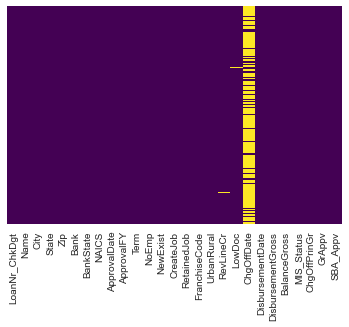

In [311]:
check_cols_with_nulls(sba)

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>DisbursementDate</b>
    </div>

In [312]:
x = sba[sba['DisbursementDate'].isna()]
print(x.shape)

(2368, 27)


In [313]:
# Not many nulls for DisbursementDate vis-a-vis to the dataset length, so drop rows with null
sba.dropna(subset=['DisbursementDate'], how='all', inplace=True)
x = sba[sba['DisbursementDate'].isna()]
print(x.shape)

(0, 27)


<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>RevLineCr</b></div>

In [314]:
len(sba[(sba['RevLineCr'] != 'Y') & (sba['RevLineCr'] != 'N')])
# too many unknowns, we will drop 'RevlineCr' later

277327

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>LowDoc</b></div>

In [315]:
sba['LowDoc'].isna().sum()

2550

In [316]:
len(sba[(sba['LowDoc'] != 'Y') & (sba['LowDoc'] != 'N')])

5965

<AxesSubplot:xlabel='LowDoc', ylabel='count'>

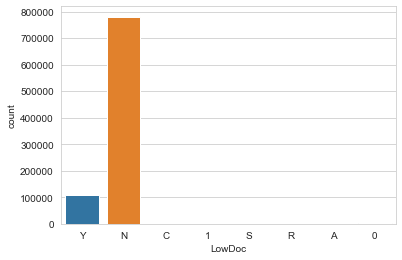

In [317]:
sns.countplot(x='LowDoc',data=sba)

* **LowDoc seems to have a bearing**

In [318]:
# 5965 records that are not 'Y' or 'N', we can drop these rows
sba = sba[(sba['LowDoc'] == 'Y') | (sba['LowDoc'] == 'N')]
len(sba[(sba['LowDoc'] != 'Y') & (sba['LowDoc'] != 'N')])

0

In [319]:
len(sba[(sba['LowDoc'] == 'Y') | (sba['LowDoc'] == 'N')])

890831

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>NewExist</b>

In [320]:
len(sba[(sba['NewExist'] != 1) & (sba['NewExist'] != 2)])

1154

<AxesSubplot:xlabel='NewExist', ylabel='count'>

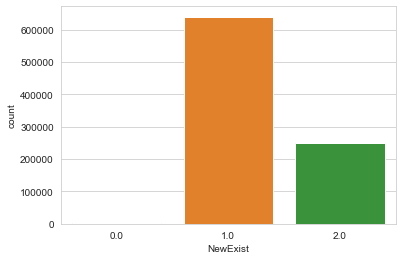

In [321]:
sns.countplot(x='NewExist',data=sba)

In [322]:
# 1154 records that are not 1 or 2, we can drop these rows as NewExist seems to have a bearing
sba = sba[(sba['NewExist'] == 1) | (sba['NewExist'] == 2)]
len(sba[(sba['NewExist'] != 1) & (sba['NewExist'] != 2)])

0

In [323]:
len(sba[(sba['NewExist'] == 1) | (sba['NewExist'] == 2)])

889677

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>CreateJob</b></div>

In [324]:
len(sba[sba['CreateJob'].isna() == True])

0

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>RetainedJob</b></div>

In [325]:
len(sba[sba['RetainedJob'].isna() == True])

0

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>FranchiseCode</b></div>

In [326]:
len(sba[sba['FranchiseCode'].isna()])

0

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>UrbanRural</b></div>

In [327]:
print(len(sba[sba['UrbanRural'].isna()]))
sba['UrbanRural'].unique()

0


array([0, 1, 2], dtype=int64)

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>NoEmp</b></div>

In [328]:
len(sba[sba['NoEmp'].isna()])

0

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Term</b></div>

In [329]:
print(len(sba[sba['Term'].isna()]))
print(len(sba[sba['Term']==0]))
print(len(sba[sba['Term']<0]))

0
805
0


<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>City</b></div>

In [330]:
len(sba[sba['City'].isna()])

30

In [331]:
# drop na in City column
sba = sba[sba['City'].notna()]
len(sba[sba['City'].isna()])

0

In [332]:
sba.head(2)

LoanNr_ChkDgt                         Name        City State    Zip  \
0     1000014003               ABC HOBBYCRAFT  EVANSVILLE    IN  47711   
1     1000024006  LANDMARK BAR & GRILLE (THE)   NEW PARIS    IN  46526   

               Bank BankState   NAICS ApprovalDate ApprovalFY  ...  RevLineCr  \
0  FIFTH THIRD BANK        OH  451120    28-Feb-97       1997  ...          N   
1   1ST SOURCE BANK        IN  722410    28-Feb-97       1997  ...          N   

   LowDoc  ChgOffDate  DisbursementDate  DisbursementGross  BalanceGross  \
0       Y         NaN        1999-02-28            60000.0        $0.00    
1       Y         NaN        1997-05-31            40000.0        $0.00    

   MIS_Status ChgOffPrinGr   GrAppv SBA_Appv  
0       P I F          0.0  60000.0  48000.0  
1       P I F          0.0  40000.0  32000.0  

[2 rows x 27 columns]

In [333]:
# Trim leading and trailing spaces
sba['City'] = sba['City'].str.strip()

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>State</b></div>

In [334]:
len(sba[sba['State'].isna()])

12

In [335]:
# drop na in State column
sba = sba[sba['State'].notna()]
len(sba[sba['State'].isna()])

0

<div style="font-family: Trebuchet MS;background-color:Chocolate;color:AliceBlue;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>MIS_Status<b> - this is the **target** variable</div>

In [336]:
len(sba.loc[sba['MIS_Status'].isna()])

1795

In [337]:
# drop na in 'MIS_Status' column
sba = sba[sba['MIS_Status'].notna()]
len(sba[sba['MIS_Status'].isna()])

0

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>NAICS</b></div>

In [338]:
len(sba[sba['NAICS'].isna()])

0

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Name</b> - keeping this feature temporarily, in case it is needed
    </div>

In [339]:
len(sba[sba['Name'].isna()])

14

In [340]:
# drop rows with na in column 'Name'
sba.dropna(subset=['Name'], how='all', inplace=True)
len(sba[sba['Name'].isna()])

0

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Check for na's in all columns</b></div>

['Bank', 'BankState', 'RevLineCr', 'ChgOffDate']


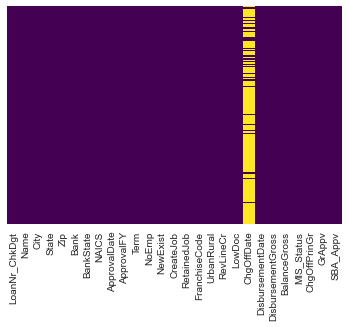

In [341]:
check_cols_with_nulls(sba)  # this function was defined earlier above

In [342]:
# Save 2
sba.to_csv(savepath + "sba_save2.csv",index=False)
FileLink(r'sba_save2.csv')  # Kaggle only
print('Saved to sba_save2.csv')

Saved to sba_save2.csv


<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>2.3 Create New Features</h2>
    </div>

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Industry</b> - The industry sector is the 1st 2 digits of NAICS
    </div>

In [343]:
sba['Industry'] = sba['NAICS'].str[0:2]
sba = sba.astype({'Industry':np.int32})

In [344]:
sba['Industry'].head(2)

0    45
1    72
Name: Industry, dtype: int32

In [345]:
sba['Industry'].unique()
# There is an invalid industry shown which is '0', caused by blank NAICS

array([45, 72, 62,  0, 33, 81, 23, 44, 42, 61, 53, 54, 31, 51, 71, 52, 21,
       32, 56, 48, 11, 92, 22, 49, 55])

In [346]:
len(sba[sba['Industry'] == 0])
# This is a bummer, as industry sector has a big effect on a business, speaking as a business 
# domain expert.  Do we drop those with NAICS = 0 ?

200089

In [347]:
# At this stage, we leave it as is and treat it as unknown industry
sba.head(2)

LoanNr_ChkDgt                         Name        City State    Zip  \
0     1000014003               ABC HOBBYCRAFT  EVANSVILLE    IN  47711   
1     1000024006  LANDMARK BAR & GRILLE (THE)   NEW PARIS    IN  46526   

               Bank BankState   NAICS ApprovalDate ApprovalFY  ...  LowDoc  \
0  FIFTH THIRD BANK        OH  451120    28-Feb-97       1997  ...       Y   
1   1ST SOURCE BANK        IN  722410    28-Feb-97       1997  ...       Y   

   ChgOffDate  DisbursementDate  DisbursementGross  BalanceGross  MIS_Status  \
0         NaN        1999-02-28            60000.0        $0.00        P I F   
1         NaN        1997-05-31            40000.0        $0.00        P I F   

   ChgOffPrinGr   GrAppv SBA_Appv Industry  
0           0.0  60000.0  48000.0       45  
1           0.0  40000.0  32000.0       72  

[2 rows x 28 columns]

In [348]:
# Check if we can impute from the name.  For example, a bar (or similar) business
sba[(sba['Name'].str.contains('bar',case=False)) & (sba['Industry'] == 0)]\
    [['Name','Industry']].head(10)

Name  Industry
692            DICKEY'S BARBECUE PIT         0
892      MID-STATE REBAR FABRICATORS         0
2763      MCDUFFY'S SPORTS BAR, INC.         0
3488  PETRUCCI'S DAIRY BARN OF MARLT         0
3941       SEOUL BARBECUE RESTAURANT         0
4022   STEAMERS RAW BAR & SEA GRILLE         0
4748             QUALITY INN BARSTOW         0
7856     THE ISLANDS RAW BAR & GRILL         0
7895  SANTA BARBARA PERIPHERALS INC.         0
8047   M'S PLACE SMOKEHOUSE BARBEQUE         0

**It's not feasible to impute missing Industry codes efficiently, so we abandon the idea.**

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Recession</b><br>
We want to account for variation due to the Great Recession (December 2007 to June 2009). Should we separate the datasets into different time periods ? Before, During, and After ?  Let's check how large the sets are later.  In the meantime, we create a new feature, Recession, with 1 for 'Y' and 0 for 'N' depending on the DisbursementDate. 
<br><br>
</div>

In [349]:
# Convert "DisbursementDate" to datetime

# sba['DisbursementDate'] = pd.to_datetime(sba['DisbursementDate'], format='%d-%b-%y')

# sba.head(2)

In [350]:
# Create new column based on condition
sba['Recession'] = np.where((sba['DisbursementDate'] >= '2007-09-01')\
                     & (sba['DisbursementDate'] <= '2009-06-30'), 1, 0)

In [351]:
print(f'Total - {len(sba)}')
y = len(sba[sba['Recession'] == 1])
n = len(sba[sba['Recession'] == 0])
print(f'Yes - {y}')
print(f'No - {n}')
print(f'Yes and No - {y+n}')


Total - 887826
Yes - 65647
No - 822179
Yes and No - 887826


<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Real Estate</b><br>
Loans backed by real estate will have terms 20 years or greater (≥240 months) and are the only loans granted for such a long term, whereas loans not backed by real estate will have terms less than 20 years ( < 240 months).<br><br>
1 - Backed By Real Estate<br>
0 - Not Backed By Real Estate<br><br>

In [352]:
# Create new column based on condition
sba['RealEstate'] = np.where(sba['Term'] >= 240, 1, 0)

In [353]:
print(f'Total - {len(sba)}')
y = len(sba[sba['RealEstate'] == 1])
n = len(sba[sba['RealEstate'] == 0])
print(f'Yes - {y}')
print(f'No - {n}')
print(f'Yes and No - {y+n}')

Total - 887826
Yes - 150700
No - 737126
Yes and No - 887826


<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>SBA_Portion</b><br>
The portion which is the percentage of the loan that is guaranteed by SBA. This is derived by calculating the ratio of the amount of the loan SBA guarantees and the gross amount approved by the bank (SBA_Appv/GrAppv) * 100.<br><br></div>

In [354]:
sba['SBA_Portion']=(sba['SBA_Appv']/sba['GrAppv']) * 100
sba.head(2)

LoanNr_ChkDgt                         Name        City State    Zip  \
0     1000014003               ABC HOBBYCRAFT  EVANSVILLE    IN  47711   
1     1000024006  LANDMARK BAR & GRILLE (THE)   NEW PARIS    IN  46526   

               Bank BankState   NAICS ApprovalDate ApprovalFY  ...  \
0  FIFTH THIRD BANK        OH  451120    28-Feb-97       1997  ...   
1   1ST SOURCE BANK        IN  722410    28-Feb-97       1997  ...   

   DisbursementGross  BalanceGross  MIS_Status  ChgOffPrinGr   GrAppv  \
0            60000.0        $0.00        P I F           0.0  60000.0   
1            40000.0        $0.00        P I F           0.0  40000.0   

   SBA_Appv  Industry Recession RealEstate SBA_Portion  
0   48000.0        45         0          0        80.0  
1   32000.0        72         0          0        80.0  

[2 rows x 31 columns]

**CityState**

In [355]:
sba["CityState"] = sba["City"] + "_" + sba["State"]
sba[["CityState", "City", "State"]].head()

CityState          City State
0    EVANSVILLE_IN    EVANSVILLE    IN
1     NEW PARIS_IN     NEW PARIS    IN
2   BLOOMINGTON_IN   BLOOMINGTON    IN
3  BROKEN ARROW_OK  BROKEN ARROW    OK
4       ORLANDO_FL       ORLANDO    FL

In [356]:
sba.head(2)

LoanNr_ChkDgt                         Name        City State    Zip  \
0     1000014003               ABC HOBBYCRAFT  EVANSVILLE    IN  47711   
1     1000024006  LANDMARK BAR & GRILLE (THE)   NEW PARIS    IN  46526   

               Bank BankState   NAICS ApprovalDate ApprovalFY  ...  \
0  FIFTH THIRD BANK        OH  451120    28-Feb-97       1997  ...   
1   1ST SOURCE BANK        IN  722410    28-Feb-97       1997  ...   

   BalanceGross  MIS_Status  ChgOffPrinGr   GrAppv  SBA_Appv  Industry  \
0        $0.00        P I F           0.0  60000.0   48000.0        45   
1        $0.00        P I F           0.0  40000.0   32000.0        72   

   Recession RealEstate SBA_Portion      CityState  
0          0          0        80.0  EVANSVILLE_IN  
1          0          0        80.0   NEW PARIS_IN  

[2 rows x 32 columns]

In [357]:
# Save 3
sba.to_csv(savepath + 'sba_save3.csv',index=False)
FileLink(r'sba_save3.csv')  # Kaggle only
print('Saved to sba_save3.csv')

Saved to sba_save3.csv


In [358]:
#sba=pd.read_csv(savepath + 'sba_save3.csv', low_memory='False')

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>2.4 Encode Categorical Features</h2>
    </div>

In [359]:
sba.select_dtypes(["object"]).nunique()

Name            771232
City             32346
State               51
Bank              5791
BankState           56
NAICS             1311
ApprovalDate      9815
ApprovalFY          47
RevLineCr           18
LowDoc               2
ChgOffDate        6429
BalanceGross        15
MIS_Status           2
CityState        44196
dtype: int64

<div style="font-family: Trebuchet MS;background-color:Chocolate;color:AliceBlue;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>MIS_Status</b><br>
    This will be the <b>target</b> variable</div>

P I F     732244
CHGOFF    155582
Name: MIS_Status, dtype: int64


<AxesSubplot:xlabel='MIS_Status', ylabel='count'>

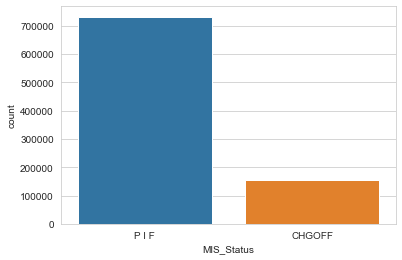

In [360]:
sns.set_style('whitegrid')
# Target variable is MIS Status, a categorical variable

print(sba['MIS_Status'].value_counts())
sns.countplot(x='MIS_Status',data=sba)

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    This shows a skewed distribution, where this bias in the target can influence many machine learning algorithms, leading some to ignore the minority class entirely, in this case, CHGOFF.  Before oversampling the data, will try as is.<br><br></div>

In [361]:
# Update column based on condition
sba['MIS_Status'] = np.where((sba['MIS_Status'] == 'P I F'), 1, 0)

In [362]:
print(sba['MIS_Status'].dtype)
sba.head(2)[['City','MIS_Status']]

int32


City  MIS_Status
0  EVANSVILLE           1
1   NEW PARIS           1

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>LowDoc</b><br>
'Y' = 1<br>
'N' = 0

In [363]:
# Update column based on condition
sba['LowDoc'] = np.where((sba['LowDoc'] == 'Y'), 1, 0)

sba.head(2)

LoanNr_ChkDgt                         Name        City State    Zip  \
0     1000014003               ABC HOBBYCRAFT  EVANSVILLE    IN  47711   
1     1000024006  LANDMARK BAR & GRILLE (THE)   NEW PARIS    IN  46526   

               Bank BankState   NAICS ApprovalDate ApprovalFY  ...  \
0  FIFTH THIRD BANK        OH  451120    28-Feb-97       1997  ...   
1   1ST SOURCE BANK        IN  722410    28-Feb-97       1997  ...   

   BalanceGross  MIS_Status  ChgOffPrinGr   GrAppv  SBA_Appv  Industry  \
0        $0.00            1           0.0  60000.0   48000.0        45   
1        $0.00            1           0.0  40000.0   32000.0        72   

   Recession RealEstate  SBA_Portion      CityState  
0          0          0         80.0  EVANSVILLE_IN  
1          0          0         80.0   NEW PARIS_IN  

[2 rows x 32 columns]

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Others</b></div>

In [364]:
# will not hash 'City' as it is already covered by 'CityState'

cols_to_drop = []
hash_constant = 900000   # fixed value so we can programmatically reproduce the hash when needed
len_data=len(sba)
for col in sba[['State','CityState']]:
  if sba[col].dtype == 'object':
    print(f'Column {col} has {sba[col].nunique()} values among {len_data}')

    if sba[col].nunique() < 25:
      print(f'One-hot encoding of {col}')
      one_hot_cols = pd.get_dummies(sba[col])
      for ohc in one_hot_cols.columns:
        sba[col + '_' + ohc] = one_hot_cols[ohc]
    else:
      print(f'Hashing of {col}')
      sba[col + '_hash'] = sba[col].apply(lambda row: int(hashlib.sha1((col + "_" + \
                                    str(row)).encode('utf-8')).hexdigest(), 16) % hash_constant)

    cols_to_drop.append(col)
print(cols_to_drop)

Column State has 51 values among 887826
Hashing of State
Column CityState has 44196 values among 887826
Hashing of CityState
['State', 'CityState']


In [365]:
sba.head(2)[['State','CityState','State_hash','CityState_hash']]

State      CityState  State_hash  CityState_hash
0    IN  EVANSVILLE_IN      705173          717067
1    IN   NEW PARIS_IN      705173          639604

In [366]:
sba.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 887826 entries, 0 to 899163
Data columns (total 34 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   LoanNr_ChkDgt      887826 non-null  int64         
 1   Name               887826 non-null  object        
 2   City               887826 non-null  object        
 3   State              887826 non-null  object        
 4   Zip                887826 non-null  int64         
 5   Bank               886328 non-null  object        
 6   BankState          886321 non-null  object        
 7   NAICS              887826 non-null  object        
 8   ApprovalDate       887826 non-null  object        
 9   ApprovalFY         887826 non-null  object        
 10  Term               887826 non-null  int64         
 11  NoEmp              887826 non-null  int64         
 12  NewExist           887826 non-null  float64       
 13  CreateJob          887826 non-null  int64   

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Convert small fields to dtype int32<b></div>

In [367]:
sba = sba.astype({'Term':np.int32, 'NoEmp':np.int32, 'NewExist':np.int32, \
                    'CreateJob':np.int32, 'RetainedJob':np.int32,\
                    'FranchiseCode':np.int32, 'UrbanRural':np.int32,\
                    'Industry':np.int32}) 

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>TimeFrame</b><br>
Save a dataset for later use where we restrict the time frame to loans by excluding those disbursed after 2010 due to the fact the term of a loan is frequently 5 or more years.
    <br><br>

In [368]:
sba_bef_2011 = sba[sba['DisbursementDate'] <= '2010-12-31'].copy()
len(sba_bef_2011[sba_bef_2011['DisbursementDate'] > '2010-12-31'])

0

In [369]:
len(sba[sba['DisbursementDate'] > '2010-12-31'])

19163

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Drop columns that are no longer needed<b></div>

In [370]:
# Save 4
sba.to_csv(savepath + 'sba_save4.csv',index=False)
FileLink(r'sba_save4.csv')         # Kaggle only
print('sba_save4.csv saved')

sba_save4.csv saved


In [371]:
cols_to_drop = ['LoanNr_ChkDgt', 'Zip', 'Bank', 'BankState', 'ApprovalDate', \
                        'ApprovalFY', 'ChgOffDate', 'BalanceGross', 'NAICS', 'ChgOffPrinGr', \
                        'Name', 'RevLineCr', 'DisbursementDate', 'City', 'State', 'CityState']

sba_bef_2011.drop(columns=cols_to_drop, inplace=True)

sba.drop(columns=cols_to_drop, inplace=True)

print('Unneeded Columns Dropped')
print(sba.info())

Unneeded Columns Dropped
<class 'pandas.core.frame.DataFrame'>
Int64Index: 887826 entries, 0 to 899163
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Term               887826 non-null  int32  
 1   NoEmp              887826 non-null  int32  
 2   NewExist           887826 non-null  int32  
 3   CreateJob          887826 non-null  int32  
 4   RetainedJob        887826 non-null  int32  
 5   FranchiseCode      887826 non-null  int32  
 6   UrbanRural         887826 non-null  int32  
 7   LowDoc             887826 non-null  int32  
 8   DisbursementGross  887826 non-null  float64
 9   MIS_Status         887826 non-null  int32  
 10  GrAppv             887826 non-null  float64
 11  SBA_Appv           887826 non-null  float64
 12  Industry           887826 non-null  int32  
 13  Recession          887826 non-null  int32  
 14  RealEstate         887826 non-null  int32  
 15  SBA_Portion        887826 

In [372]:
# Save sba_bef_2011
## save this dataset to working dir
sba_bef_2011.to_csv(savepath + "sba_bef_2011.csv",index=False)
FileLink(r'sba_bef_2011.csv')  # Kaggle only
print("sba_bef_2011.csv saved")

sba_bef_2011.csv saved


In [373]:
# Save 5
sba.to_csv(savepath + 'sba_save5.csv',index=False)
FileLink(r'sba_save5.csv')         # Kaggle only
print('sba_save5.csv saved')

sba_save5.csv saved


In [374]:
print(len(sba))
print(len(sba_bef_2011))

887826
868663


<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Check for Infinite Values<b></div>

In [375]:
check_infinity_nan(sba,'sba')

checking for infinity

printing the count of infinity values
sba contains 0 infinite values

Does sba have Nan or Null values ?  False


<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Check Correlations</b></div>

[Text(0, 0.5, 'Term'),
 Text(0, 1.5, 'NoEmp'),
 Text(0, 2.5, 'NewExist'),
 Text(0, 3.5, 'CreateJob'),
 Text(0, 4.5, 'RetainedJob'),
 Text(0, 5.5, 'FranchiseCode'),
 Text(0, 6.5, 'UrbanRural'),
 Text(0, 7.5, 'LowDoc'),
 Text(0, 8.5, 'DisbursementGross'),
 Text(0, 9.5, 'MIS_Status'),
 Text(0, 10.5, 'GrAppv'),
 Text(0, 11.5, 'SBA_Appv'),
 Text(0, 12.5, 'Industry'),
 Text(0, 13.5, 'Recession'),
 Text(0, 14.5, 'RealEstate'),
 Text(0, 15.5, 'SBA_Portion'),
 Text(0, 16.5, 'State_hash'),
 Text(0, 17.5, 'CityState_hash')]

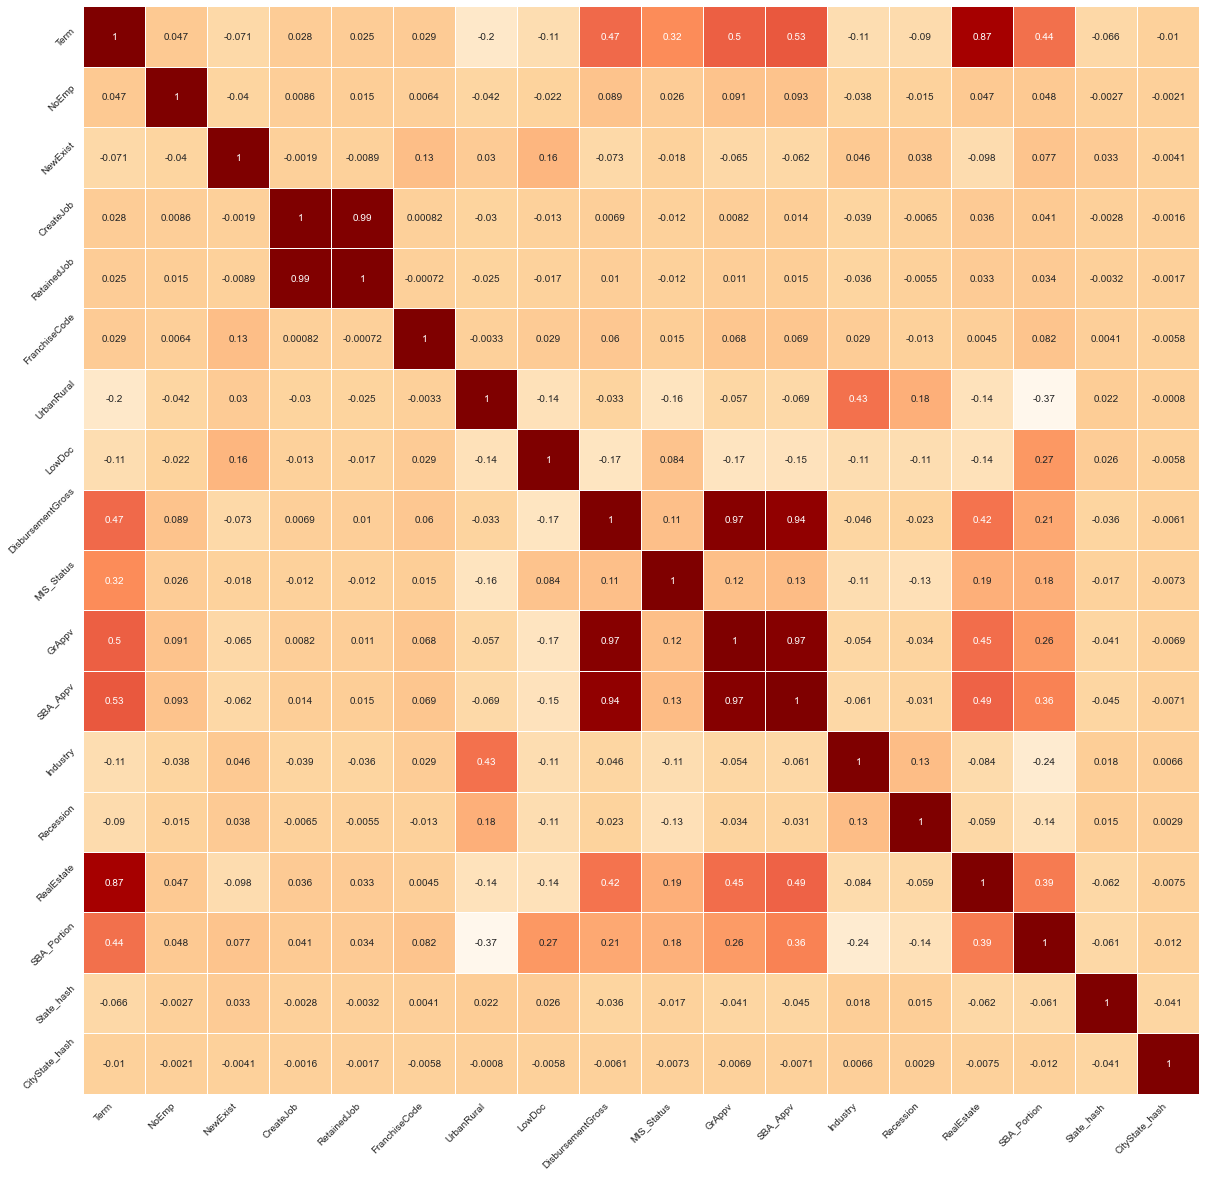

In [376]:
fig, ax = plt.subplots(figsize=(20,20))

g = sns.heatmap(
    sba.corr(),
    annot=True,
    ax=ax,
    cmap='OrRd',
    cbar=False,
    linewidth=1
)

g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_yticklabels(g.get_yticklabels(), rotation=45, horizontalalignment='right')

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>3. Build Model Using XGBoost</h2>
    </div>

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>3.1 Prepare Data</h2>
    </div>

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>3.1 Model 1</h2>
    </div>

In [377]:
# Select subset of predictors
X = sba.copy()

# Select target
y = X.pop('MIS_Status')

In [378]:
model1 = process_model(X, y)
model1_results = model1.prep_run_model(0.7, "Metrics : Full SBA Not Oversampled")

MIS_Status Count :  Counter({1: 732244, 0: 155582})

Shapes Before And After Splitting Dataset :
X (887826, 17)   y (887826,)
X_train (621478, 17)   y_train (621478,)
X_valid (133174, 17)   y_valid (133174,)
X_test (133174, 17)   y_test (133174,)

Please wait, Fitting model can take time ...
Fitting model completed.

Metrics : Full SBA Not Oversampled
MAE: 0.055686545421779025
MSE: 0.055686545421779025
RMSE: 0.23597996826378934

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84     23373
           1       0.96      0.97      0.97    109801

    accuracy                           0.94    133174
   macro avg       0.91      0.89      0.90    133174
weighted avg       0.94      0.94      0.94    133174


Accuracy for model: 94.43


<div style="font-family: Trebuchet MS;background-color:HoneyDew;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Accuracy for model is good; but ... Precision, Recall, and f1-score of classification 0 (CHGOFF) is much lower than that of 1 (P I F). This may be because MIS_Status is heavily skewed towards 1 (P I F).  To solve this, we try Oversampling the data, in the next section.</b></div>

In [379]:
if savepath != "./":   # not Kaggle
    engine.say("SBA Machine Learning Model 1 completed.")
    engine.runAndWait()

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;"><h2>3.2 OverSample</h2>
    </div>

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;"><h2>3.2.1 Model 2</h2>
    </div>

In [380]:
# Select subset of predictors
X = sba.copy()

# Select target
y = X.pop('MIS_Status')

In [381]:
model2 = process_model(X, y)
model2.osample()
model2_results = model2.prep_run_model(0.7, "Metrics : Full SBA Oversampled")

MIS_Status Count :  Counter({1: 732244, 0: 155582})
887826
887826
Before Oversampling :  Counter({1: 732244, 0: 155582})
After Oversampling  :  Counter({1: 732244, 0: 732244})

Shapes Before And After Splitting Dataset :
X (887826, 17)   y (887826,)
X_train (1025141, 17)   y_train (1025141,)
X_valid (219673, 17)   y_valid (219673,)
X_test (219674, 17)   y_test (219674,)

Please wait, Fitting model can take time ...
Fitting model completed.

Metrics : Full SBA Oversampled
MAE: 0.066507945901408
MSE: 0.066507945901408
RMSE: 0.2578913451463775

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93    109883
           1       0.94      0.93      0.93    109790

    accuracy                           0.93    219673
   macro avg       0.93      0.93      0.93    219673
weighted avg       0.93      0.93      0.93    219673


Accuracy for model: 93.35


<div style="font-family: Trebuchet MS;background-color:HoneyDew;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>After oversampling of the minority class (CHGOFF), class 0 (CHGOFF) now has similar precision, recall, and f1-score as class 1 (P I F).
<br><br>     
The accuracy score is slightly lower than when not oversampled, but this should be more accurate in predicting the target. </b></div>

In [382]:
if savepath != "./":   # not Kaggle
    engine.say("SBA Machine Learning Model 2 completed.")
    engine.runAndWait()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

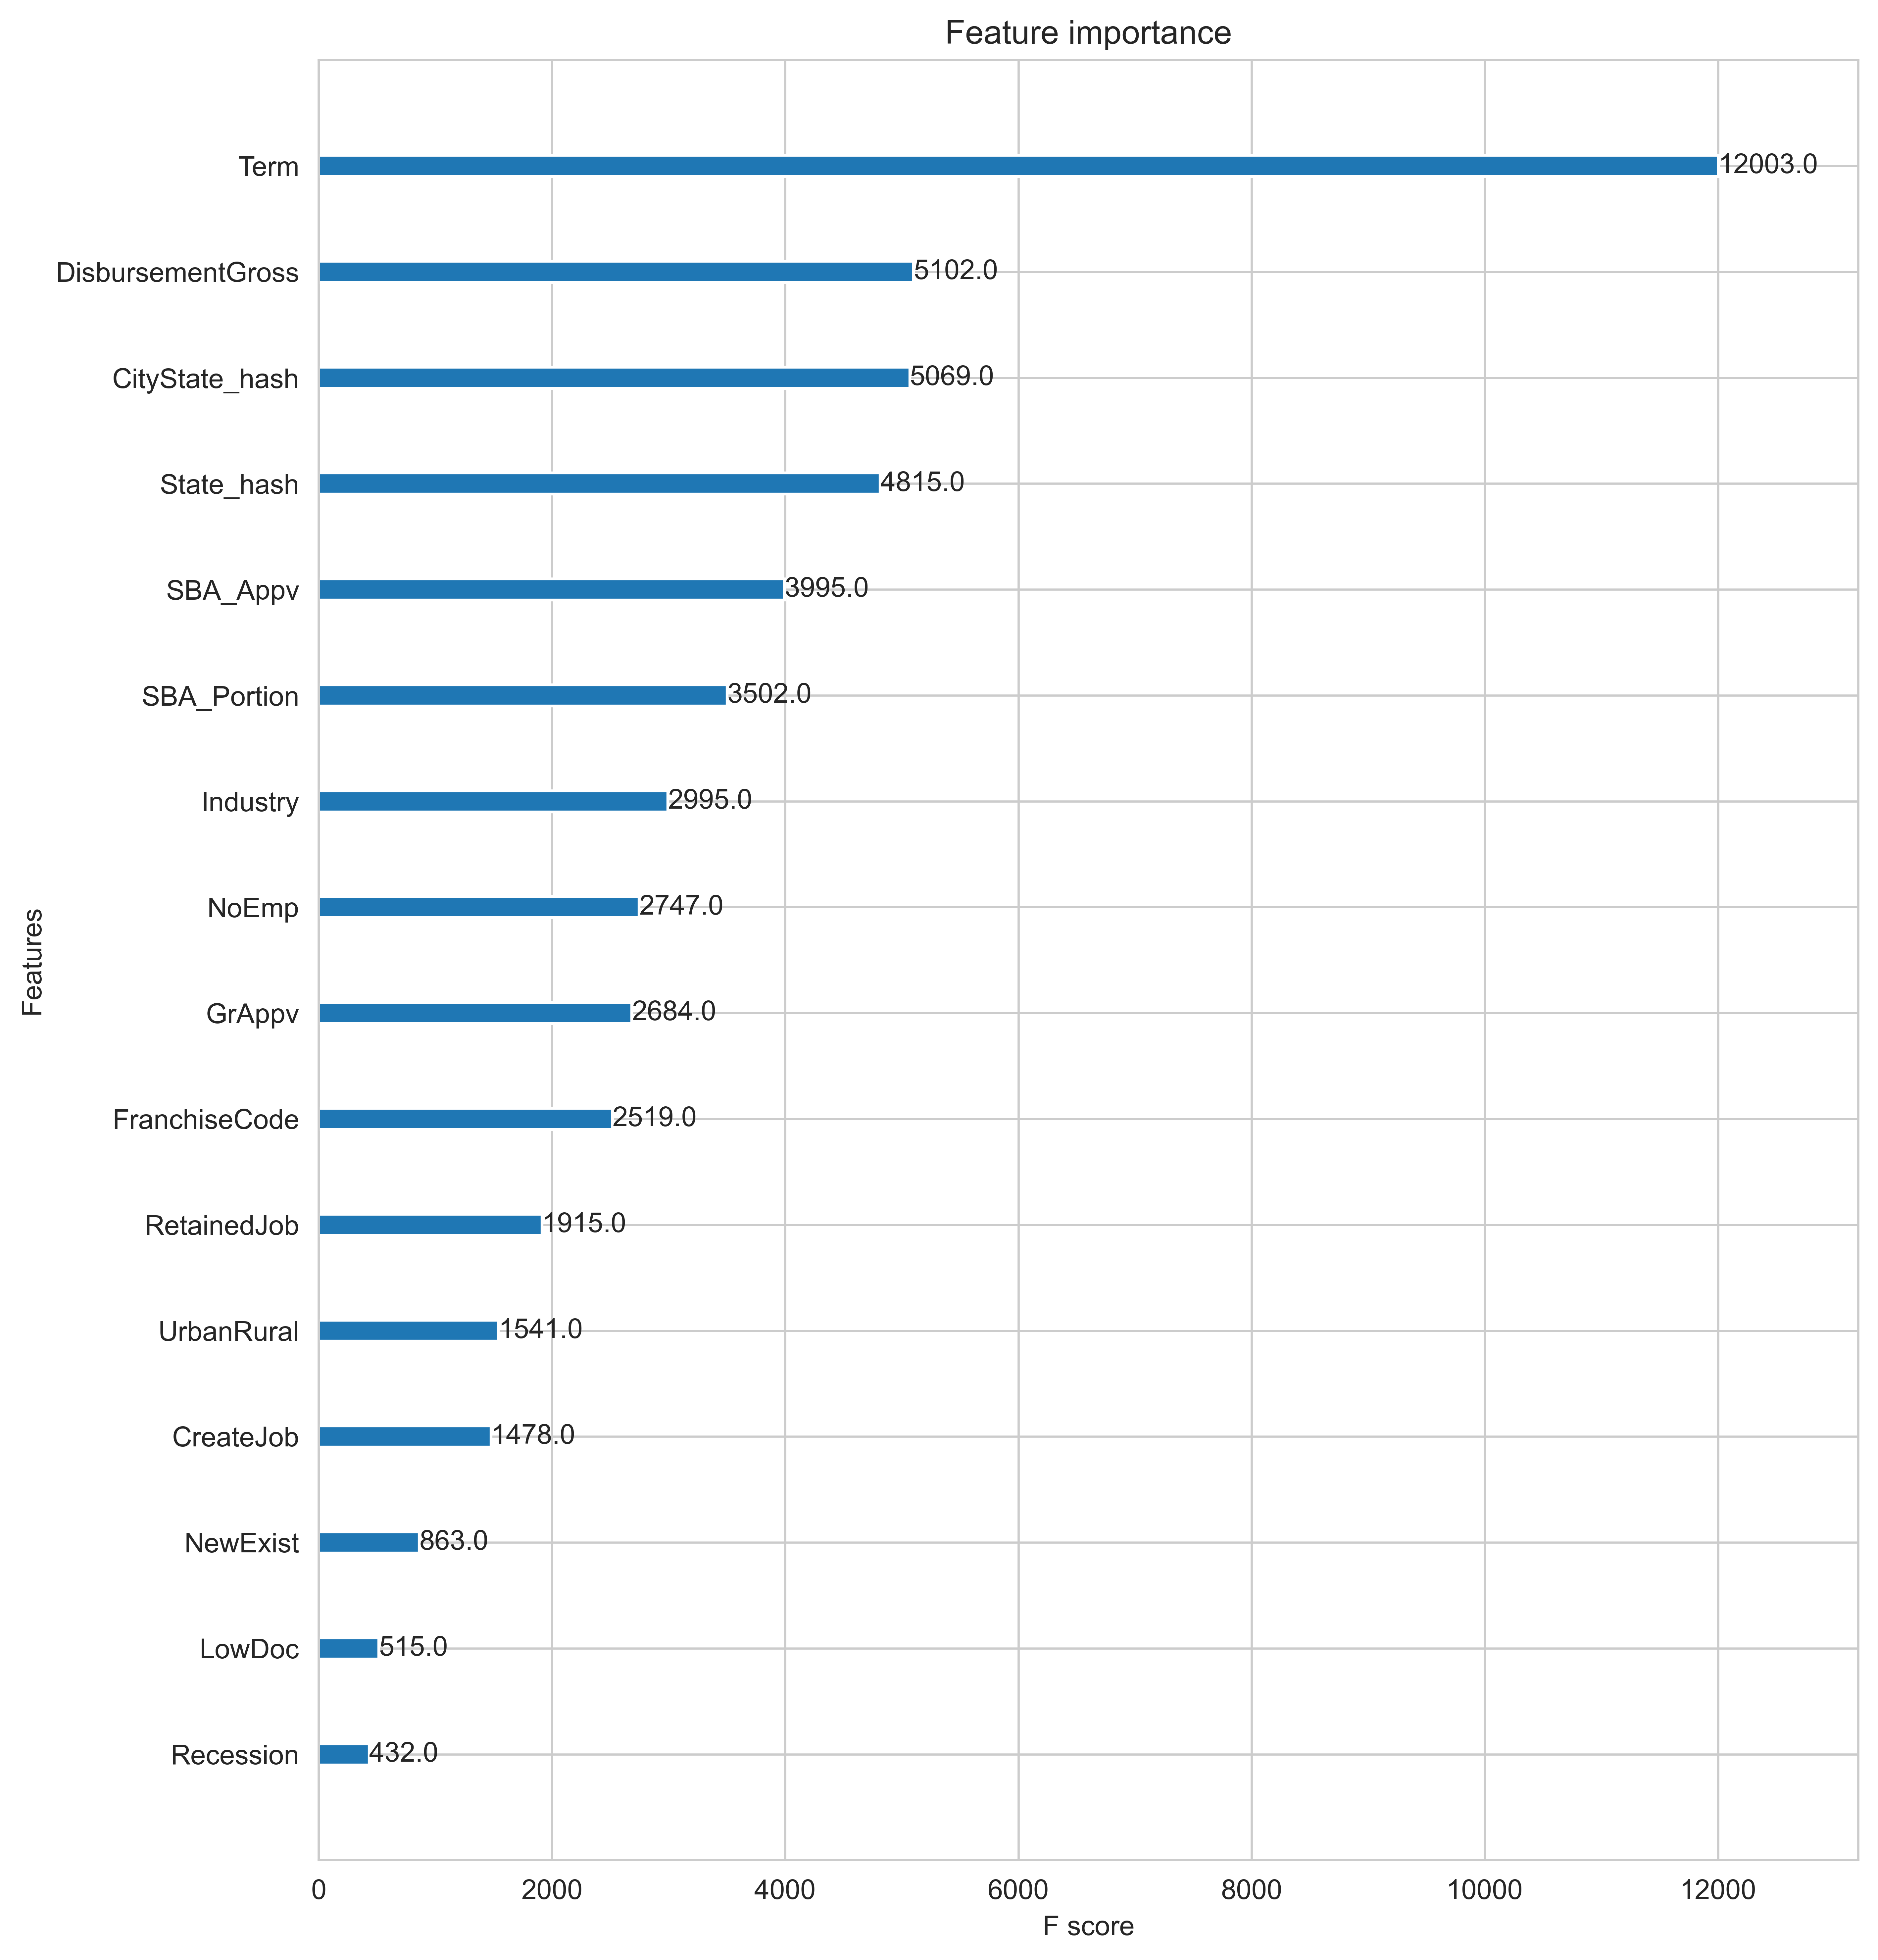

In [383]:
# Plot feature importance

plot_features(model2_results['xg_model'], (10,12))

<div style="font-family: Trebuchet MS;background-color:HoneyDew;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Observation</b><br>
    I was hoping to see <b>Industry</b> at a much higher position here, but apparently the incomplete data on industry had an effect.<br><br>
Furthermore, <b>Recession</b> has to be at a very high position, but is at the bottom instead.  This could be due to <b>Recession</b> data being highly skewed towards 1 (Not Recession).<br><br>
<b>Real Estate</b> should have good importance too, but it may be highly skewed as well.

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>3.2.2 Model 3</h2>
    <b>Build a Model Dataset Excluding Year 2011 and Above</b>

We restrict the time frame to loans by excluding those disbursed after 2010 due to the fact the term of a loan is frequently 5 or more years.
       </div>

In [384]:
sba_df = pd.read_csv(savepath + "sba_bef_2011.csv")

print(sba_df.columns)

# Select subset of predictors
X = sba_df.copy()

# Select target
y = X.pop('MIS_Status')

Index(['Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
       'FranchiseCode', 'UrbanRural', 'LowDoc', 'DisbursementGross',
       'MIS_Status', 'GrAppv', 'SBA_Appv', 'Industry', 'Recession',
       'RealEstate', 'SBA_Portion', 'State_hash', 'CityState_hash'],
      dtype='object')


In [385]:
model3 = process_model(X, y)
model3.osample()
model3_results = model3.prep_run_model(0.7, "Metrics : SBA Before 2011 Oversampled")

MIS_Status Count :  Counter({1: 714212, 0: 154451})
868663
868663
Before Oversampling :  Counter({1: 714212, 0: 154451})
After Oversampling  :  Counter({1: 714212, 0: 714212})

Shapes Before And After Splitting Dataset :
X (868663, 17)   y (868663,)
X_train (999896, 17)   y_train (999896,)
X_valid (214264, 17)   y_valid (214264,)
X_test (214264, 17)   y_test (214264,)

Please wait, Fitting model can take time ...
Fitting model completed.

Metrics : SBA Before 2011 Oversampled
MAE: 0.06547530149721839
MSE: 0.06547530149721839
RMSE: 0.25588142077379983

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94    107092
           1       0.94      0.93      0.93    107172

    accuracy                           0.93    214264
   macro avg       0.93      0.93      0.93    214264
weighted avg       0.93      0.93      0.93    214264


Accuracy for model: 93.45


<div style="font-family: Trebuchet MS;background-color:HoneyDew;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>We get a slightly better score.  Will use this dataset as the last dataset, for now.</b></div>

In [386]:
if savepath != "./":   # not Kaggle
    engine.say("SBA Machine Learning Model 3 completed.")
    engine.runAndWait()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

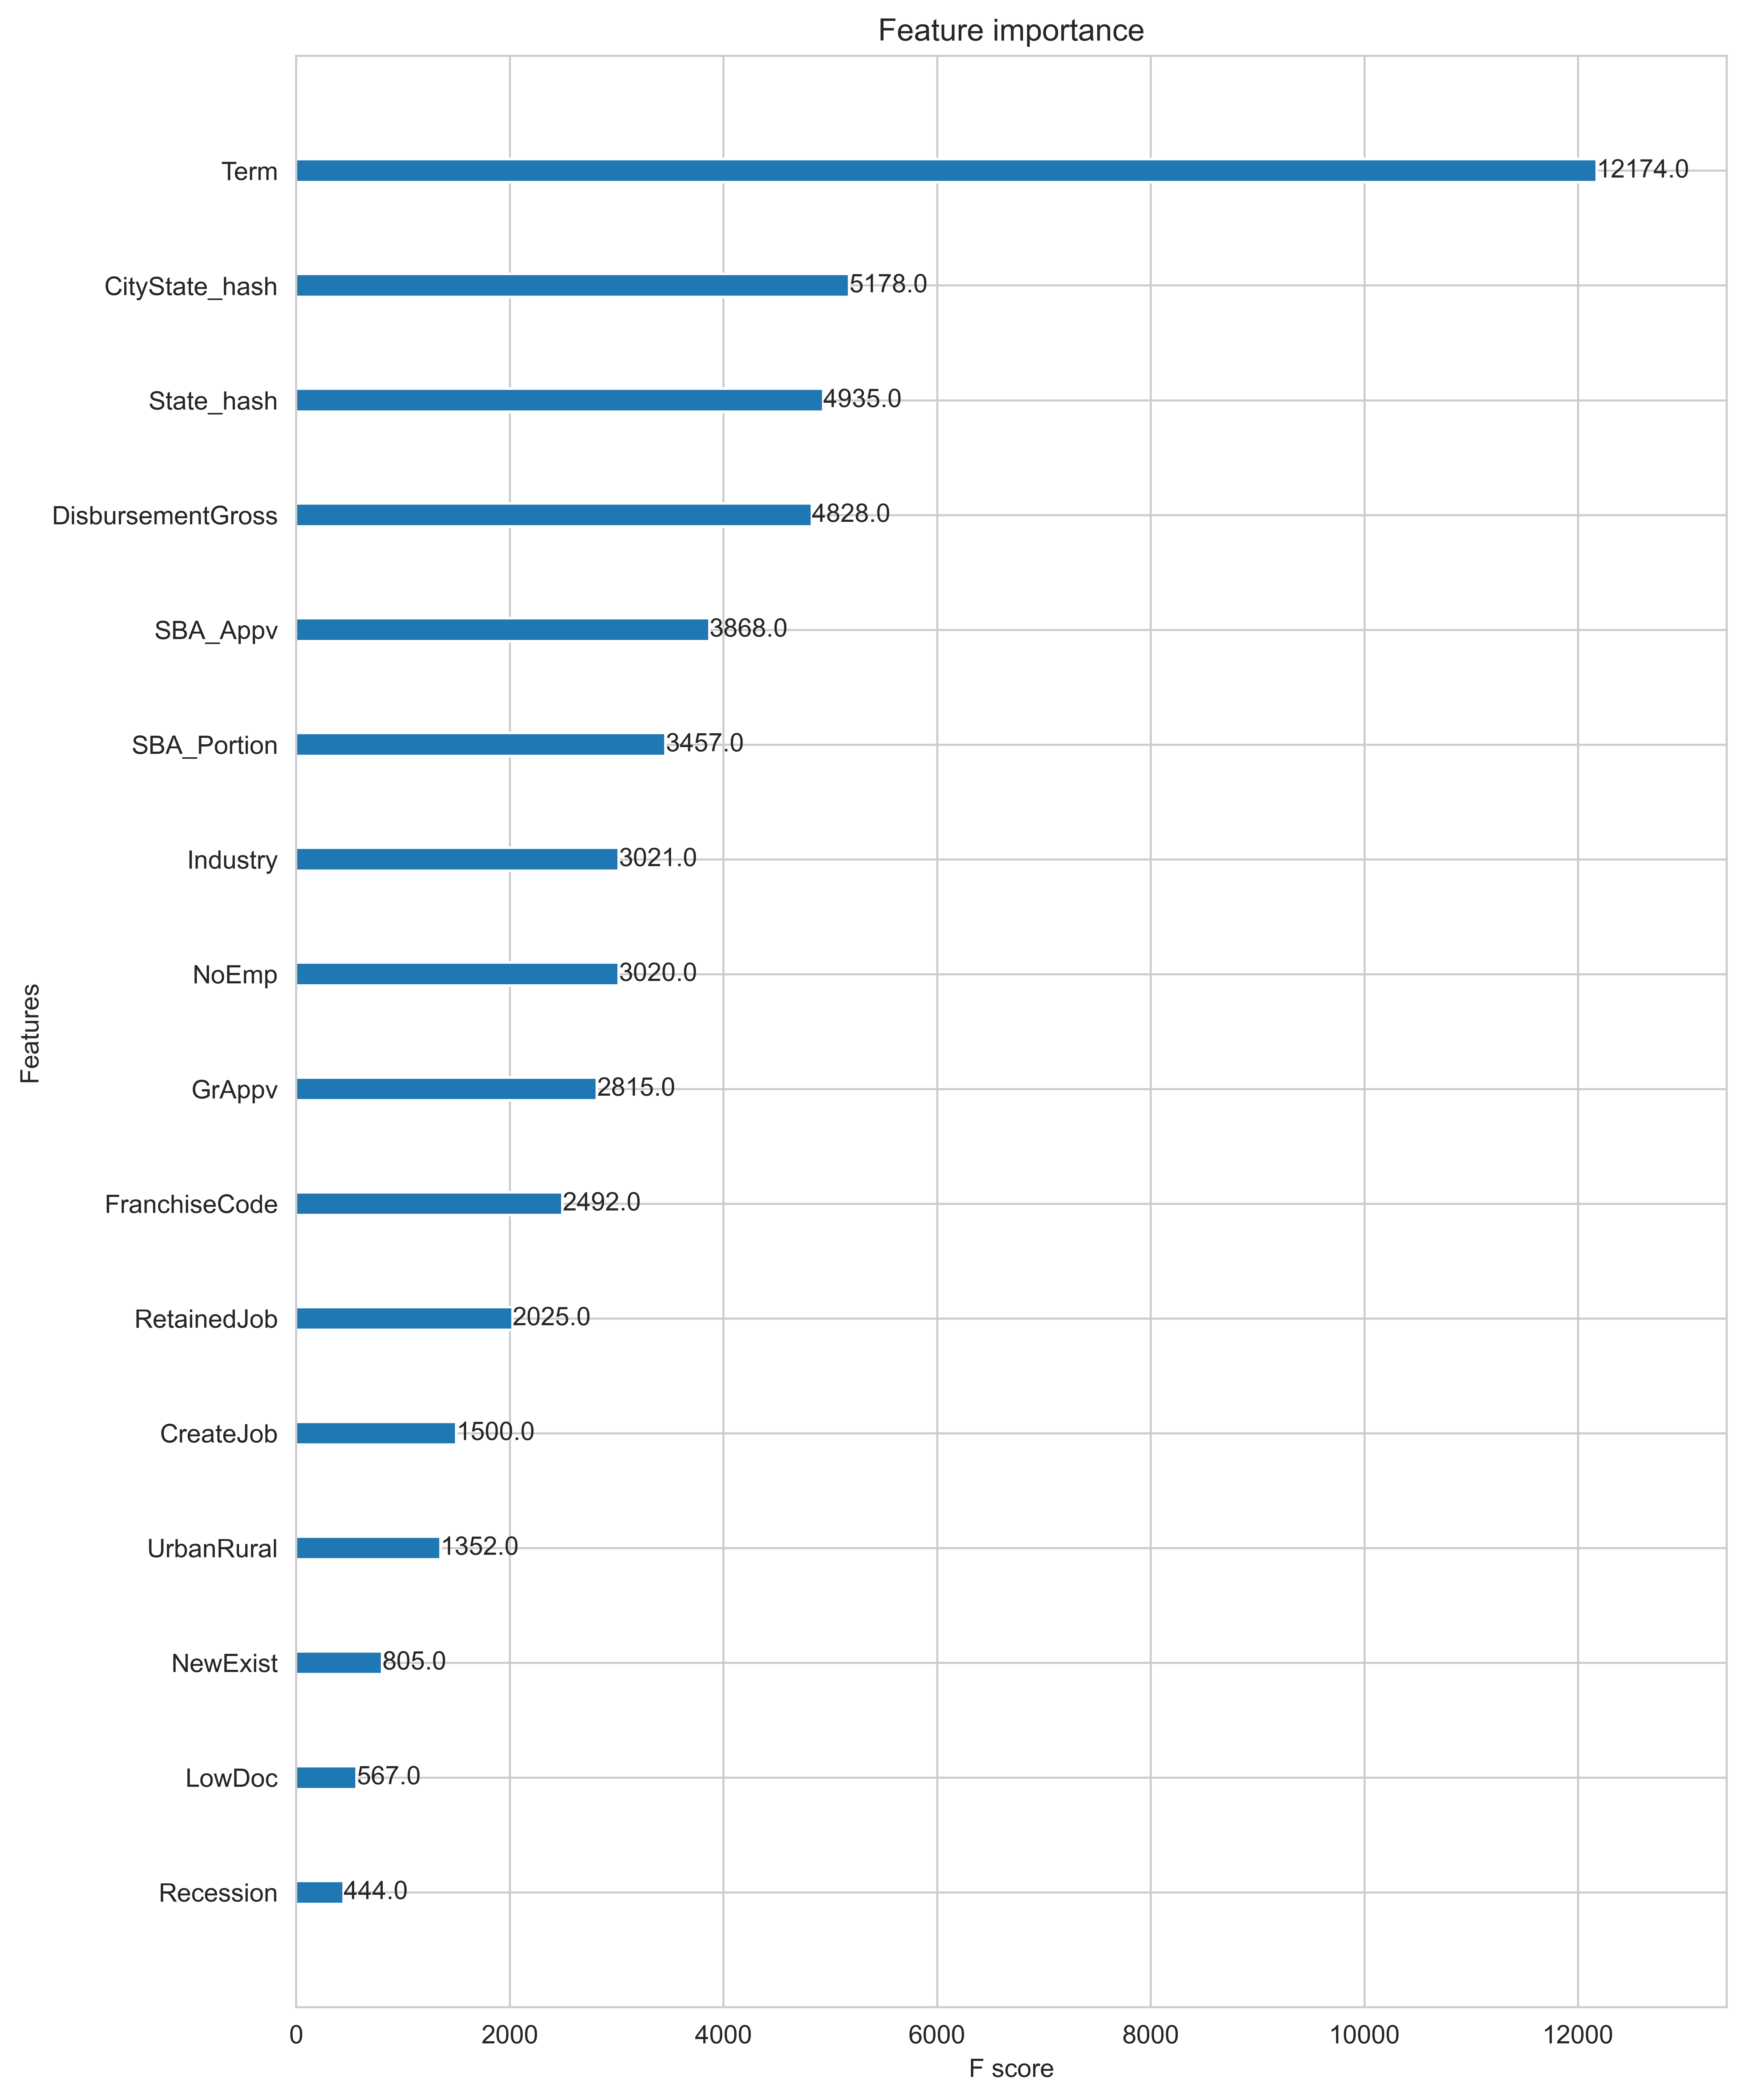

In [387]:
# Plot feature importance
my_model3 = model3_results['xg_model']
plot_features(my_model3, (10,14))

In [388]:
# Save 6
sba_df.to_csv(savepath + 'sba_save6.csv',index=False)
FileLink(r'sba_save6.csv')  # Kaggle only
print('sba_save6.csv saved')

sba_save6.csv saved


<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>4. Test Model</h2>
    </div>
    

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>4.1 Test Model with Test Dataset</h2>
    Test Dataset was previously unseen by the model.
    </div>

In [389]:
X_test = model3_results['X_test']
y_test = model3_results['y_test']

In [390]:
# Get predictions
predictions6 = my_model3.predict(X_test)
model_eval(y_test, predictions6)

MAE: 0.06521394167942351
MSE: 0.06521394167942351
RMSE: 0.25537020515209585

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94    107090
           1       0.94      0.93      0.93    107174

    accuracy                           0.93    214264
   macro avg       0.93      0.93      0.93    214264
weighted avg       0.93      0.93      0.93    214264


Accuracy for model: 93.48


<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>4.2 Test Model with User Input</h2>
    </div>

<div style="font-family: Trebuchet MS;background-color:HoneyDew;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;"><b>So let's assume the following are the entries of a user, through a user interface, looking for a prediction from our model.</b></div>

In [391]:
'''
17 Entries :
 0   Term                 
 1   NoEmp                
 2   NewExist             
 3   CreateJob            
 4   RetainedJob          
 5   FranchiseCode        
 6   UrbanRural           
 7   LowDoc               
 8   DisbursementGross         
 9   GrAppv             
 10  SBA_Appv           
 11  Industry             
 12  Recession            
 13  RealEstate           
 14  SBA_Portion 
 15  City
 16  State       
'''

user_input = [2,0,1,0,0,1,0,0,50000,50000,25000,71,0,0,50,'EVANSVILLE','IN']

city = user_input[15]
state = user_input[16]
city_state = city + "_" + state

state_hash = int(hashlib.sha1(('State' + "_" + \
                              str(state)).encode('utf-8')).hexdigest(), 16) % 900000
city_state_hash = int(hashlib.sha1(('CityState' + "_" + \
                              str(city_state)).encode('utf-8')).hexdigest(), 16) % 900000

print(state_hash)
print(city_state_hash)

user_input[16] = state_hash
user_input.append(city_state_hash)
user_input.pop(15)

print(user_input)

705173
717067
[2, 0, 1, 0, 0, 1, 0, 0, 50000, 50000, 25000, 71, 0, 0, 50, 705173, 717067]


In [392]:
features = np.array([user_input])   

# using inputs to predict the output
pred = my_model3.predict(features)
print("Prediction: {}".format(pred))

Prediction: [0]


**Predictions:**<br>
- near 1 -> can approve
- lower than 0.5 -> do not approve

Of course, in real life, will need to check further using other data or models if available.

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>5. Mutual Information Scores</h2>
 A general-purpose metric, normally used before selecting and building a model, but used here in the end, for comparison.
    </div>

In [406]:
sba_df = pd.read_csv(savepath + "sba_save6.csv")
print(sba_df.columns)

# Select subset of predictors
X = sba_df.copy()

# Select target
y = X.pop('MIS_Status')

Index(['Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
       'FranchiseCode', 'UrbanRural', 'LowDoc', 'DisbursementGross',
       'MIS_Status', 'GrAppv', 'SBA_Appv', 'Industry', 'Recession',
       'RealEstate', 'SBA_Portion', 'State_hash', 'CityState_hash'],
      dtype='object')


In [407]:
# a long time to run
model_mi = process_model(X, y)
osample_xy = model_mi.osample()
mi_scores = make_mi_scores(osample_xy['X_over'], osample_xy['y_over'])

MIS_Status Count :  Counter({1: 714212, 0: 154451})
868663
868663
Before Oversampling :  Counter({1: 714212, 0: 154451})
After Oversampling  :  Counter({1: 714212, 0: 714212})

Please wait, Mutual Information gathering can take time (about 30 mins) ...
Mutual Information gathering done ...


In [408]:
if savepath != "./":   # not Kaggle
    engine.say("SBA Mutual Information completed.")
    engine.runAndWait()

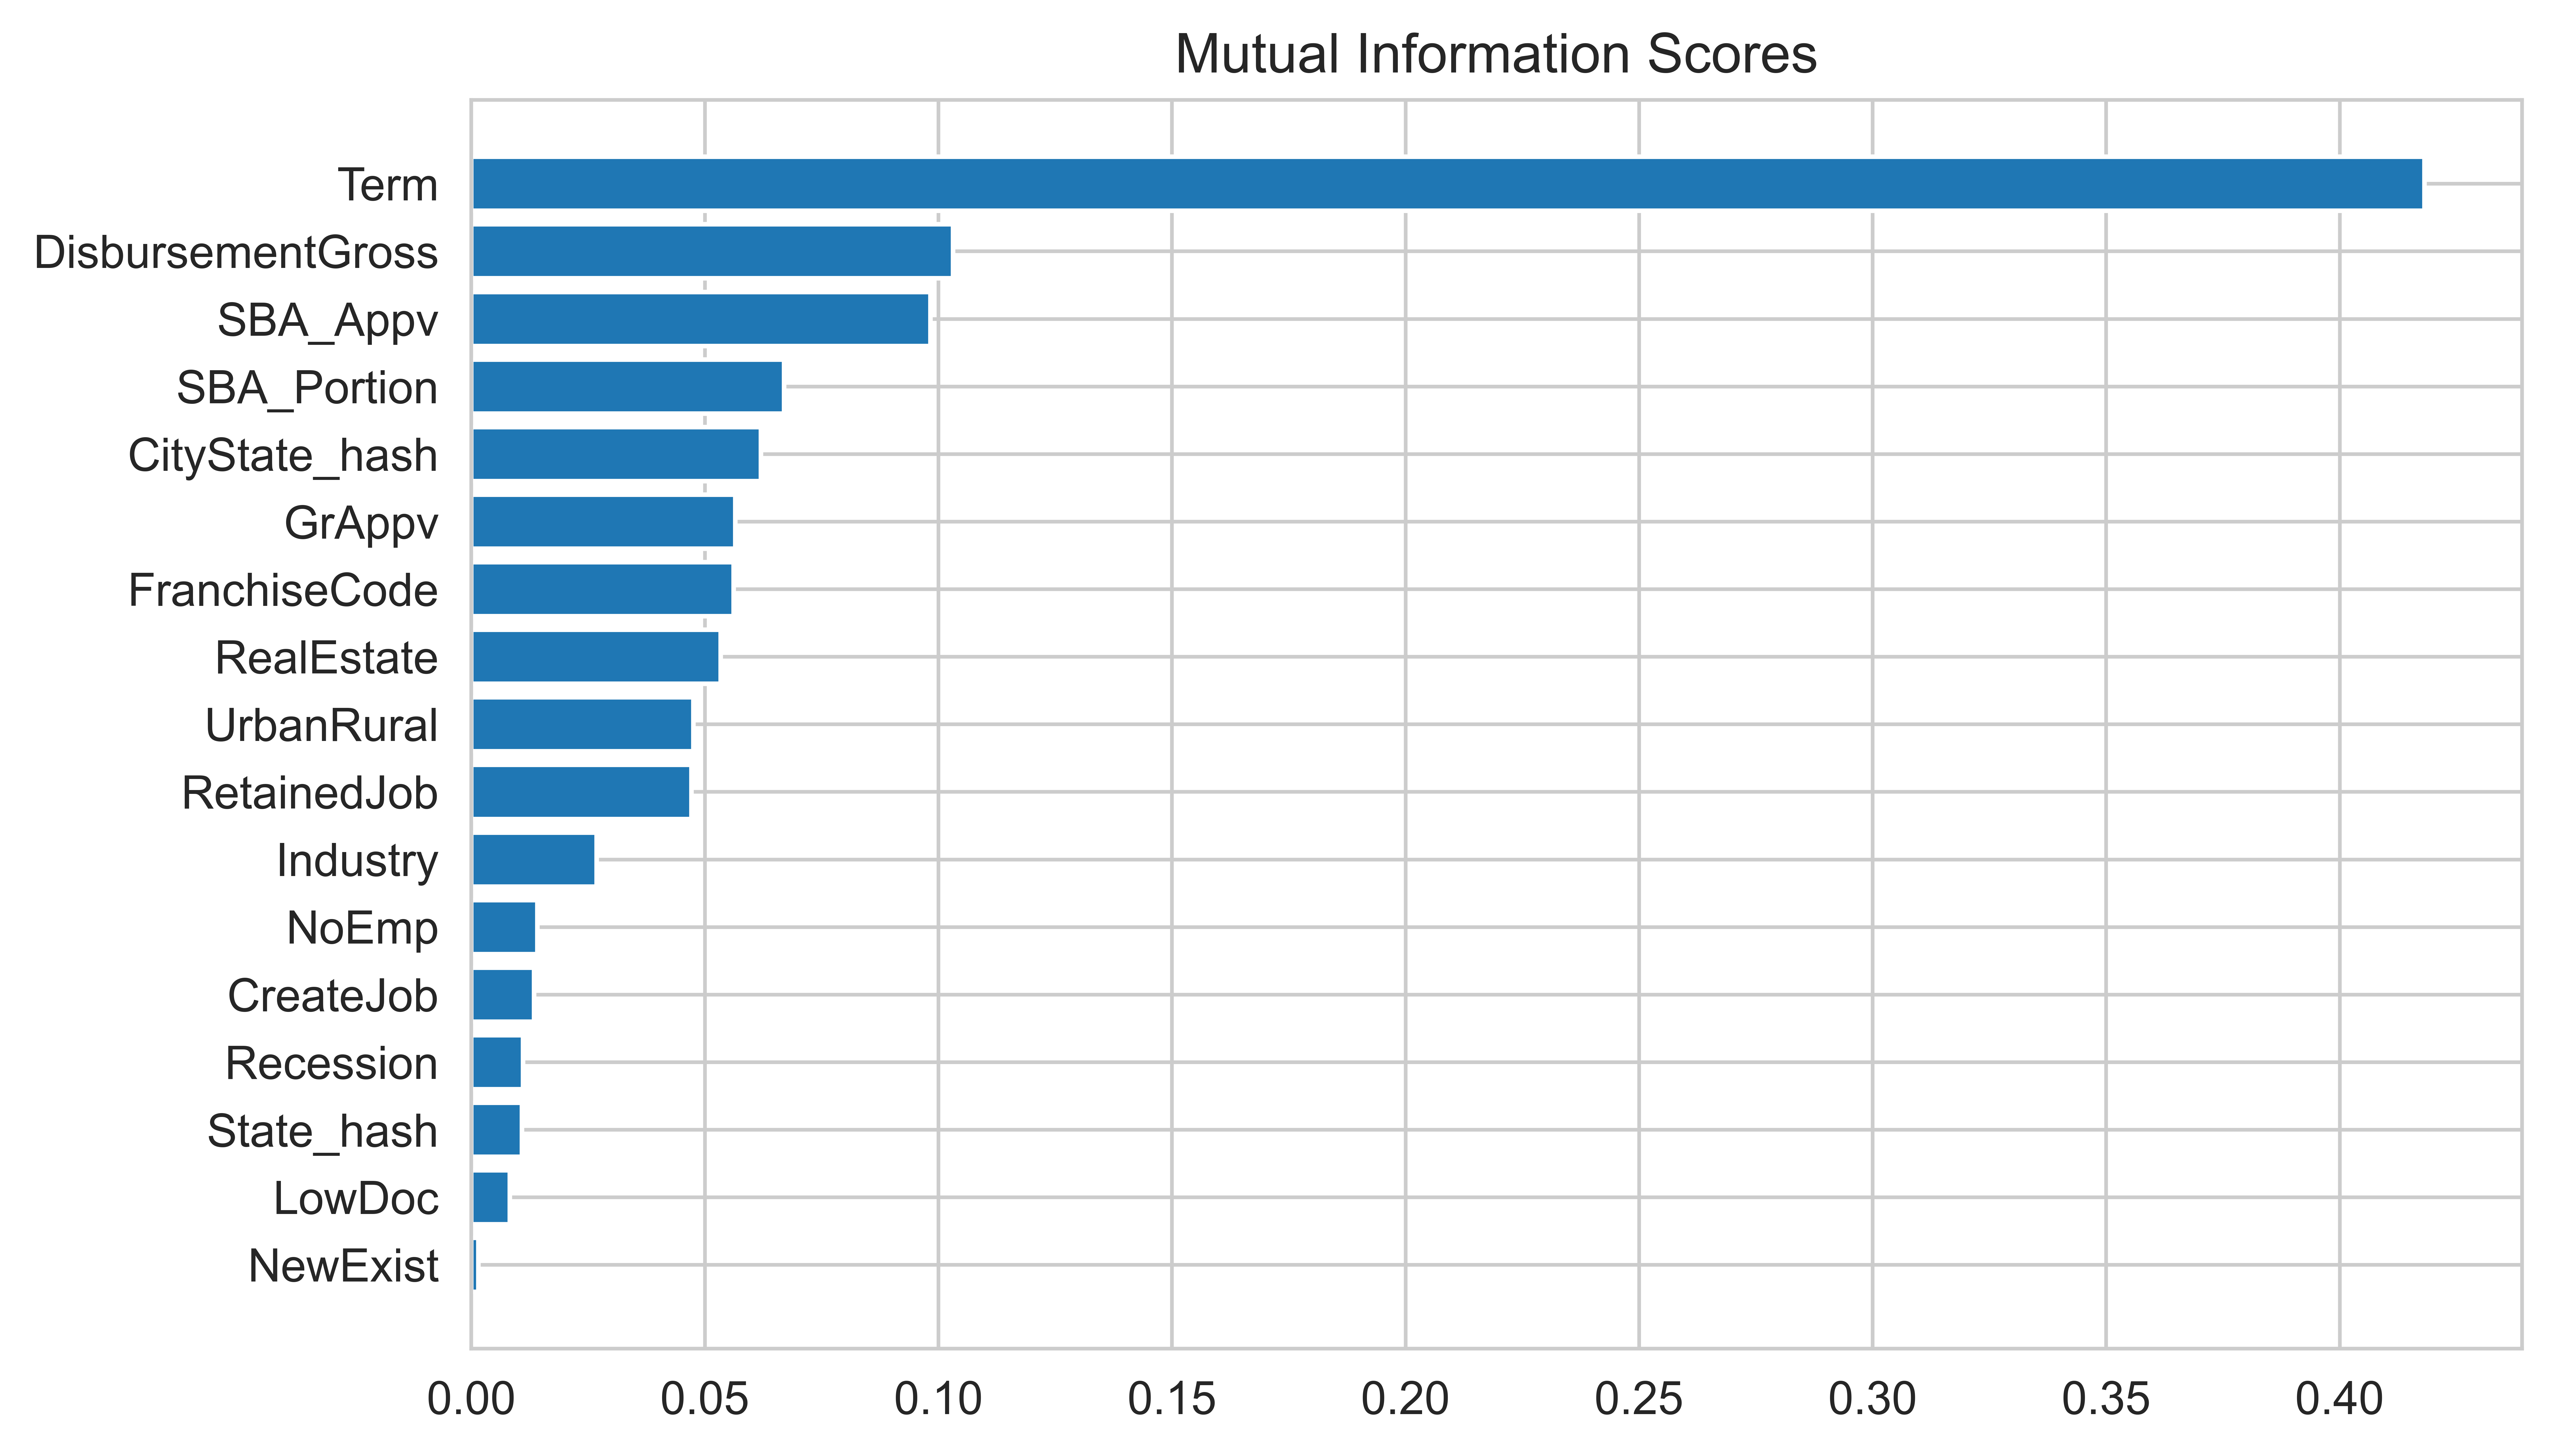

In [409]:
plt.figure(dpi=1200, figsize=(8, 5))
plot_mi_scores(mi_scores)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

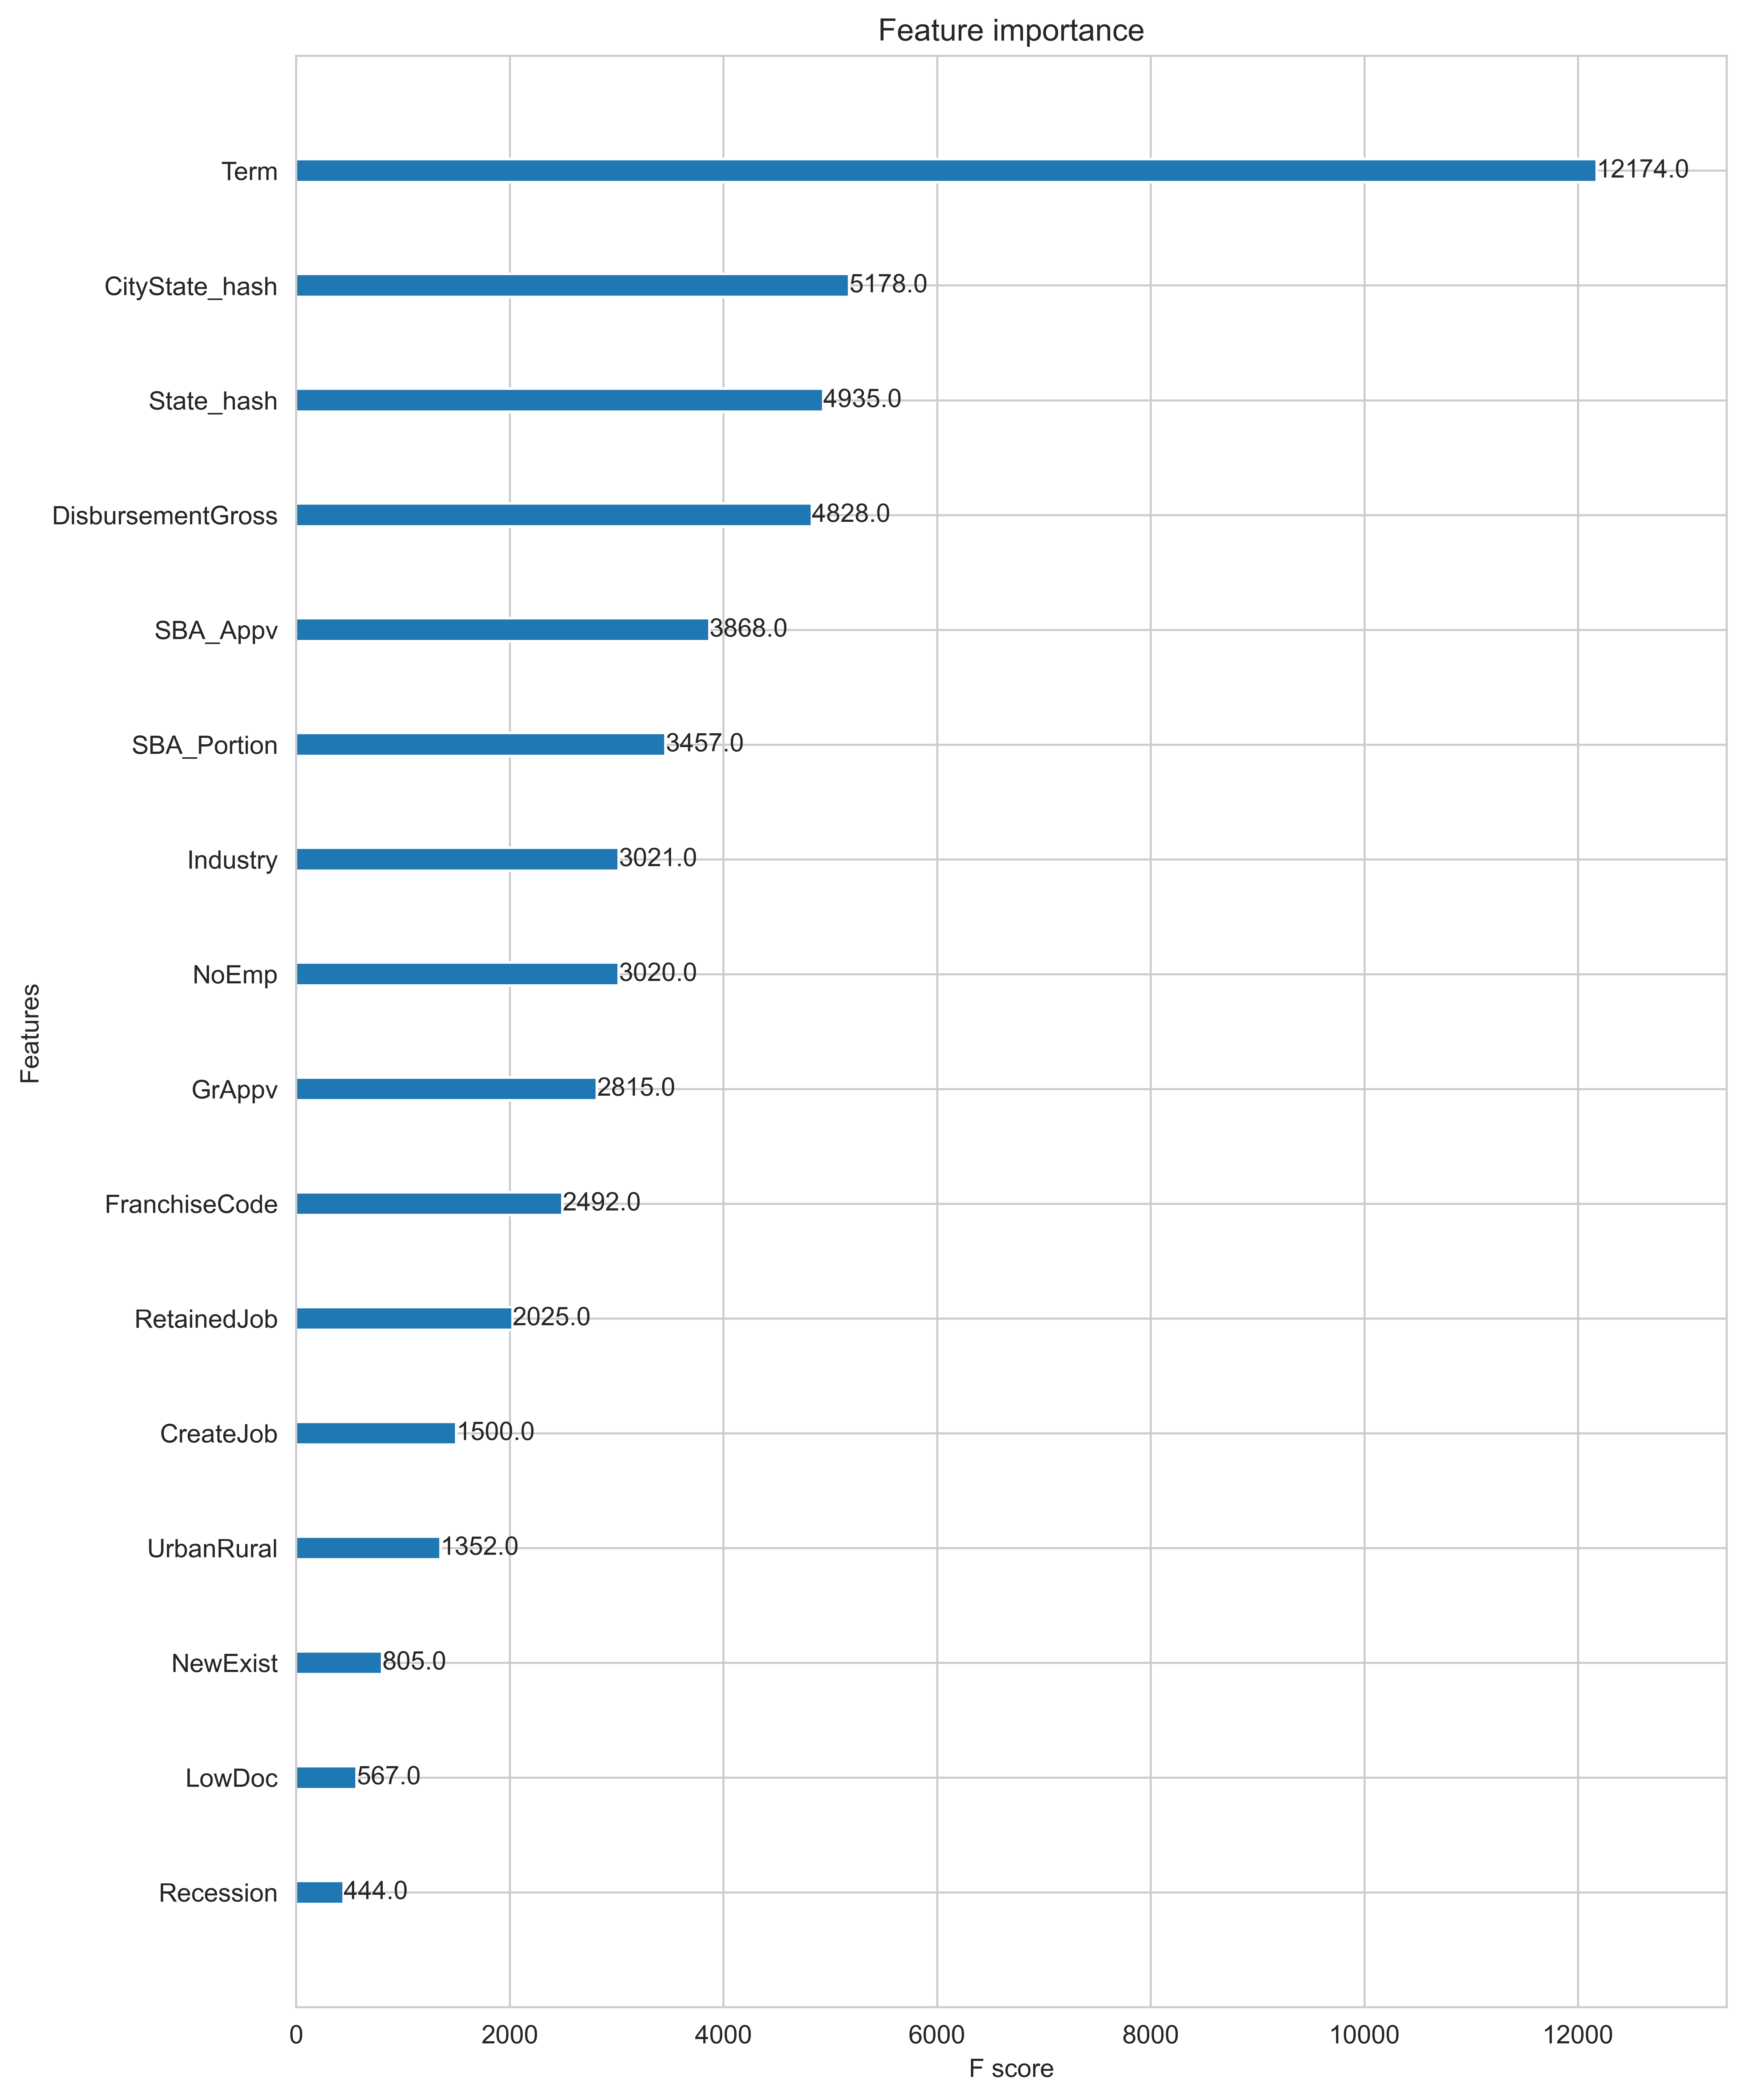

In [410]:
# Plot feature importance
plot_features(my_model3, (10,14))

<div style="font-family: Trebuchet MS;background-color:HoneyDew;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">The importance ranked by <b>Mutual Information</b> and <b>XGBoost Feature Importance</b> metrics are different.  Which ranking do you think is more reasonable ?</div>

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>6. Trim Dataset</h2><br>
After the preprocessing and encoding steps, we had a total of <b>17 features</b> and not all of these may be useful in forecasting the loan default. Alternatively we can select the <b>top 5 or top 8 features</b>, based on the feature importance plot above, which had a major contribution in forecasting loan defaults.<br><br>

If the model performance is similar in both the cases, that is – by using 17 features and by using 5-8 features, then we should use only the top 8 features, in order to keep the model simpler and more efficient.

The idea is to have a less complex model without compromising on the overall model performance.
</div>

In [411]:
sba = pd.read_csv(savepath + "sba_save6.csv")
print(sba.shape)

# Select subset of predictors
X = sba.copy()

# Select target
y = X.pop('MIS_Status')

#Let's retain the top 9 from Mutual Information metric (about half of 17)
mi_features = ['Term', 'DisbursementGross', 'SBA_Appv', 'SBA_Portion', 'CityState_hash', \
         'FranchiseCode', 'GrAppv', 'RealEstate','UrbanRural']

Xmi = X[mi_features]

#Let's retain the top 9 from Feature Importance metric (about half of 17)
fi_features = ['Term', 'DisbursementGross', 'CityState_hash','State_hash', \
         'SBA_Appv', 'SBA_Portion', 'Industry', 'NoEmp', 'GrAppv']

Xfi = X[fi_features] 

(868663, 18)


In [412]:
model_mi = process_model(Xmi, y)
model_mi.osample()
model_mi_results = model_mi.prep_run_model(0.7, "Mutual Information Metrics")

MIS_Status Count :  Counter({1: 714212, 0: 154451})
868663
868663
Before Oversampling :  Counter({1: 714212, 0: 154451})
After Oversampling  :  Counter({1: 714212, 0: 714212})

Shapes Before And After Splitting Dataset :
X (868663, 17)   y (868663,)
X_train (999896, 9)   y_train (999896,)
X_valid (214264, 9)   y_valid (214264,)
X_test (214264, 9)   y_test (214264,)

Please wait, Fitting model can take time ...
Fitting model completed.

Mutual Information Metrics
MAE: 0.07274203785983646
MSE: 0.07274203785983646
RMSE: 0.26970731888444643

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93    107092
           1       0.93      0.92      0.93    107172

    accuracy                           0.93    214264
   macro avg       0.93      0.93      0.93    214264
weighted avg       0.93      0.93      0.93    214264


Accuracy for model: 92.73


In [413]:
if savepath != "./":   # not Kaggle
    engine.say("Trimmed Dataset by Mutual Information completed.")
    engine.runAndWait()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

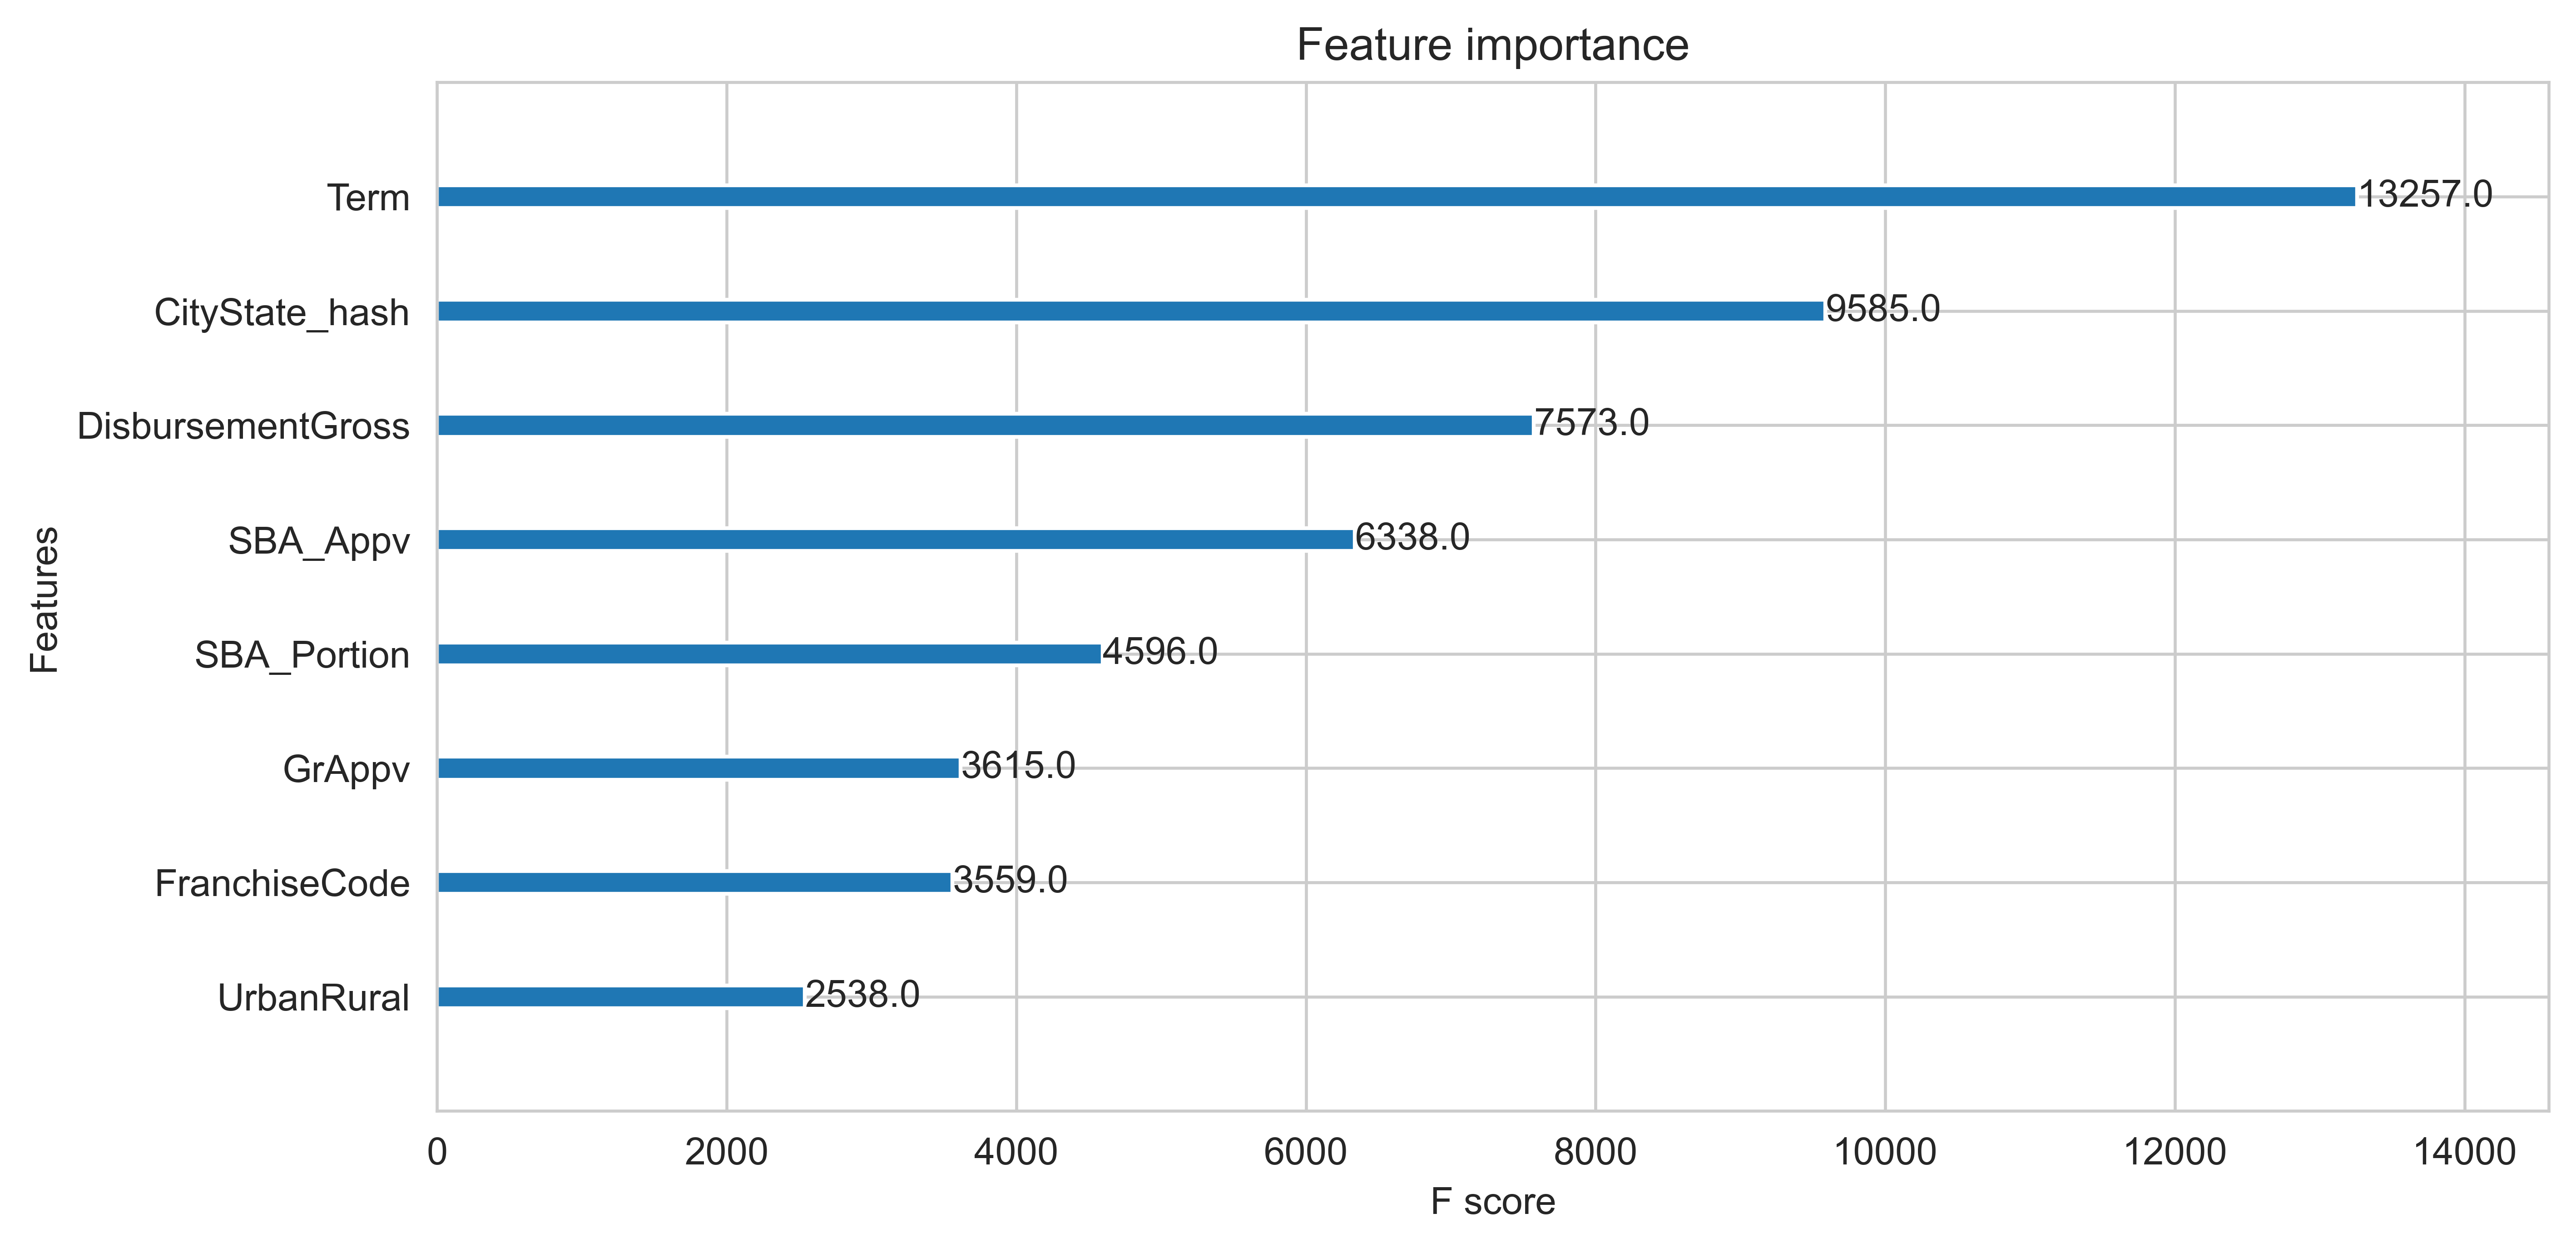

In [414]:
# Plot mutual information
my_model_mi = model_mi_results['xg_model']
plot_features(my_model_mi, (10,5))

In [415]:
# Test with Unseen test data

X_test = model_mi_results['X_test']
X_test_mi = X_test[mi_features]

y_test = model_mi_results['y_test']

predictions_mi = my_model_mi.predict(X_test_mi)
model_eval(y_test, predictions_mi)

MAE: 0.07230799387671284
MSE: 0.07230799387671284
RMSE: 0.26890145755780653

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93    107090
           1       0.94      0.92      0.93    107174

    accuracy                           0.93    214264
   macro avg       0.93      0.93      0.93    214264
weighted avg       0.93      0.93      0.93    214264


Accuracy for model: 92.77


In [416]:
model_fi = process_model(Xfi, y)
model_fi.osample()
model_fi_results = model_fi.prep_run_model(0.7, "Feature Importance Metrics")

MIS_Status Count :  Counter({1: 714212, 0: 154451})
868663
868663
Before Oversampling :  Counter({1: 714212, 0: 154451})
After Oversampling  :  Counter({1: 714212, 0: 714212})

Shapes Before And After Splitting Dataset :
X (868663, 17)   y (868663,)
X_train (999896, 9)   y_train (999896,)
X_valid (214264, 9)   y_valid (214264,)
X_test (214264, 9)   y_test (214264,)

Please wait, Fitting model can take time ...
Fitting model completed.

Feature Importance Metrics
MAE: 0.0758550199753575
MSE: 0.0758550199753575
RMSE: 0.2754179006080714

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92    107092
           1       0.93      0.92      0.92    107172

    accuracy                           0.92    214264
   macro avg       0.92      0.92      0.92    214264
weighted avg       0.92      0.92      0.92    214264


Accuracy for model: 92.41


In [417]:
if savepath != "./":   # not Kaggle
    engine.say("Trimmed Dataset by Feature Importance completed.")
    engine.runAndWait()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

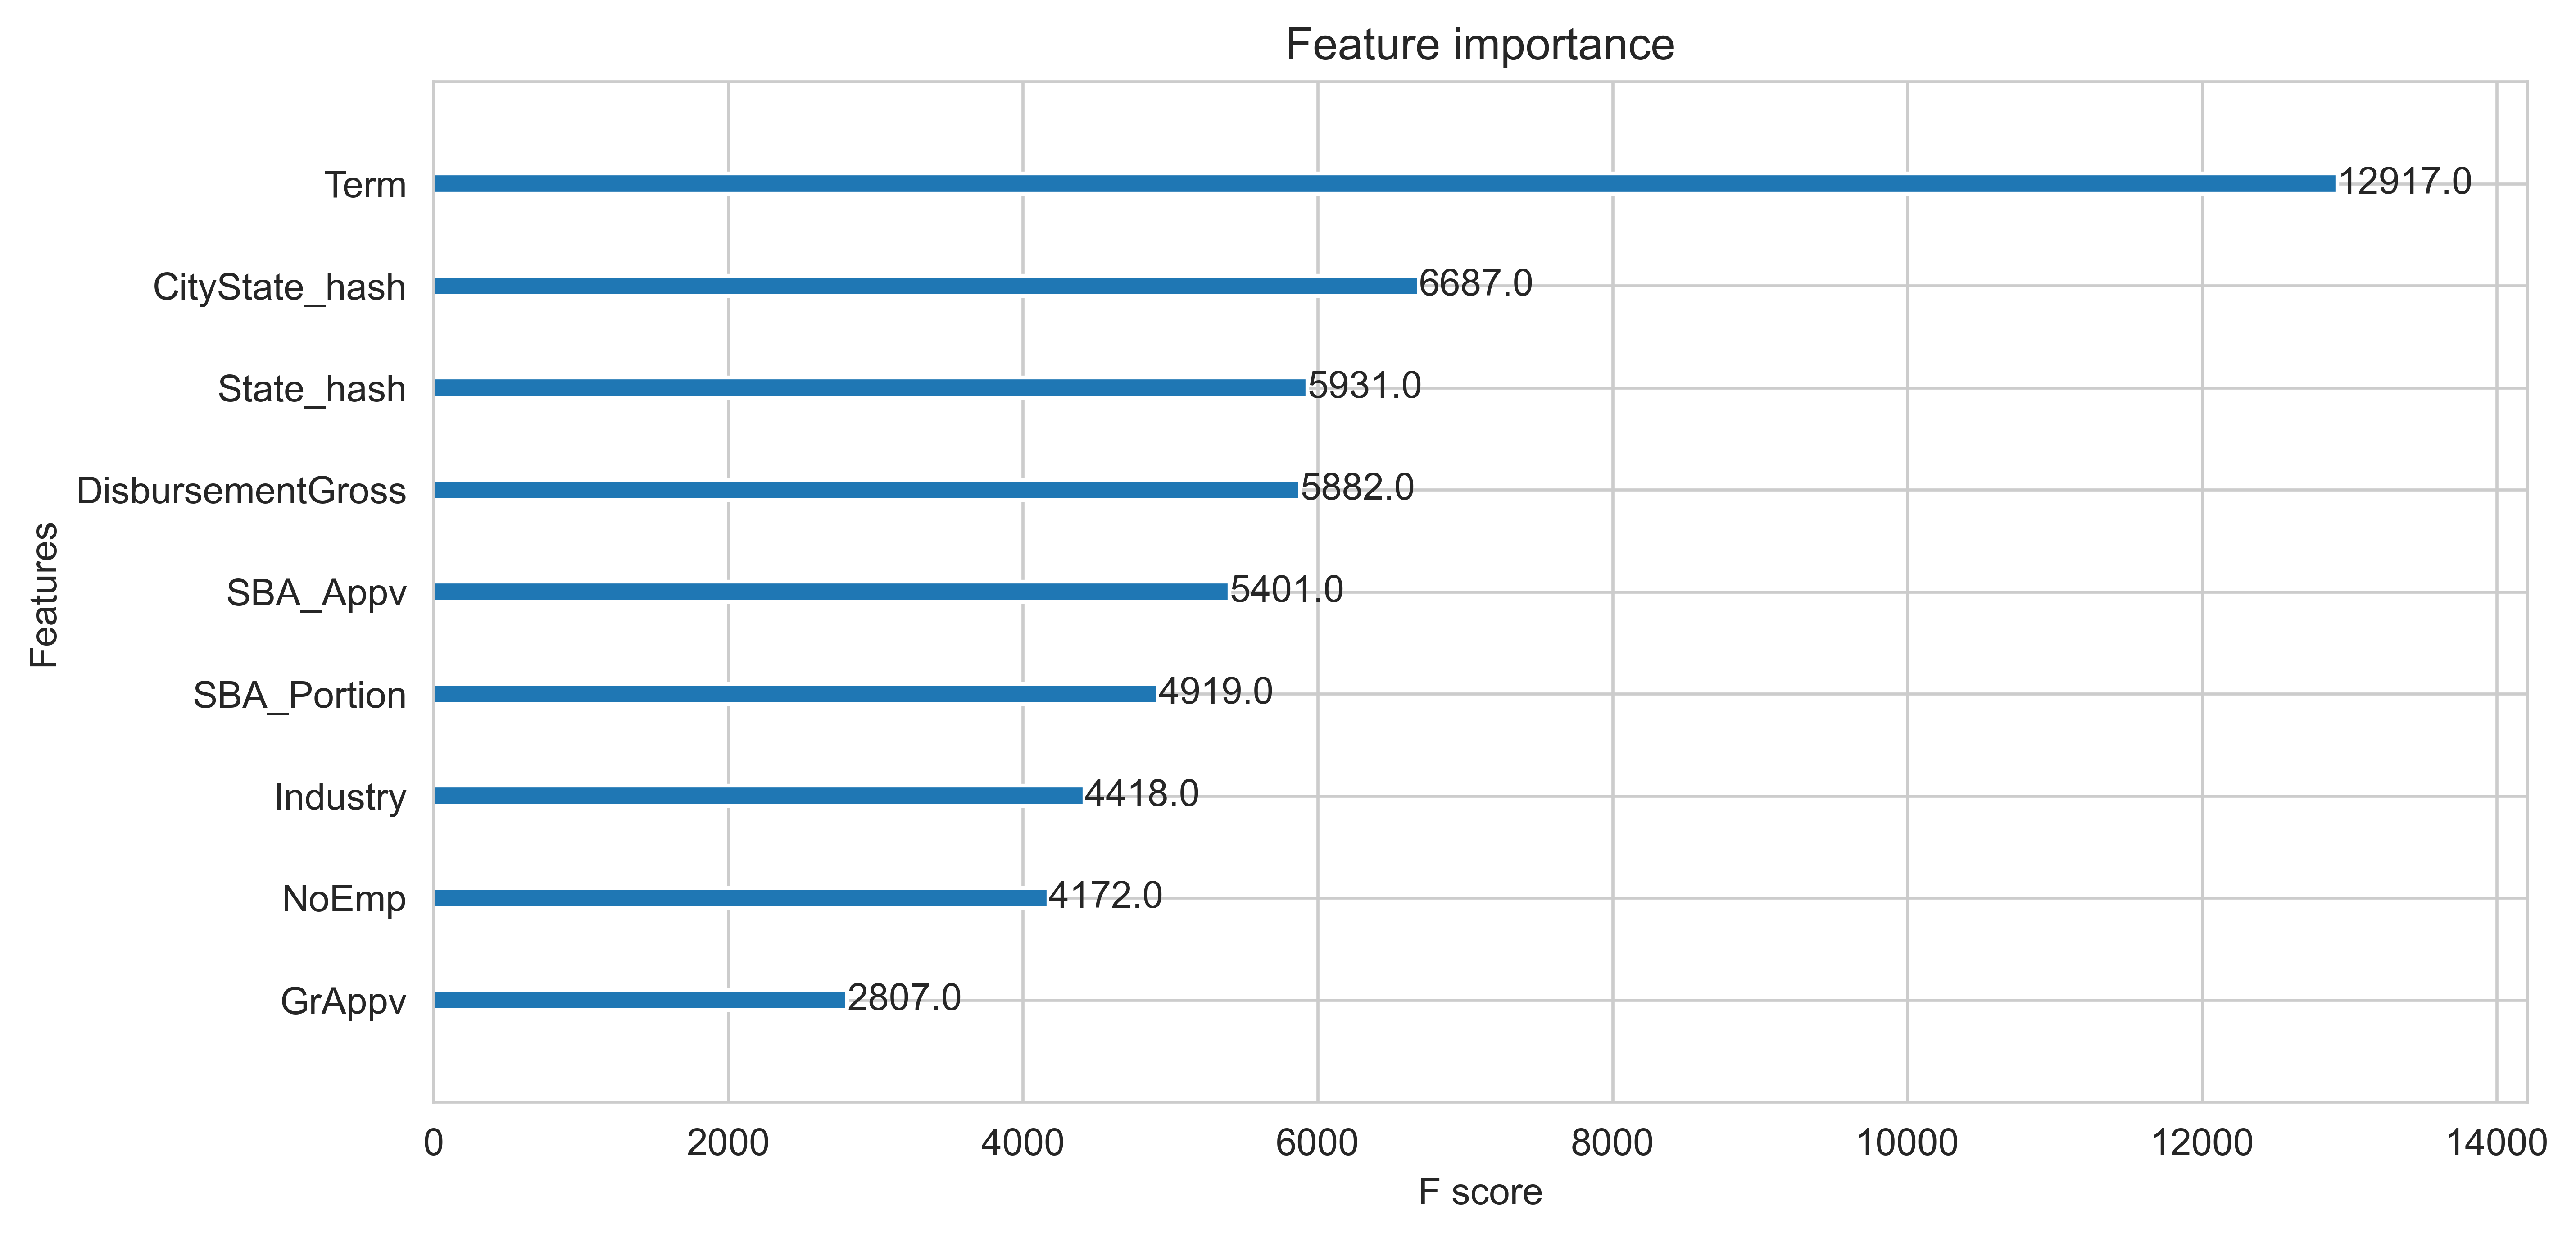

In [418]:
# Plot feature importance
my_model_fi = model_fi_results['xg_model']
plot_features(my_model_fi, (10,5))

In [419]:
# Test with Unseen test data

X_test = model_fi_results['X_test']
X_test_fi = X_test[fi_features]

y_test = model_fi_results['y_test']

predictions_fi = my_model_fi.predict(X_test_fi)
model_eval(y_test, predictions_fi)

MAE: 0.07543497741104432
MSE: 0.07543497741104432
RMSE: 0.27465428707931056

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92    107090
           1       0.93      0.92      0.92    107174

    accuracy                           0.92    214264
   macro avg       0.92      0.92      0.92    214264
weighted avg       0.92      0.92      0.92    214264


Accuracy for model: 92.46


<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>7. Results</h2>
</div>

**Do we select the full dataset, or the trimmed dataset ?**<br>

Approx 1 point accuracy difference between trimmed and full features dataset.  We can stick with the full features for now; although, the trimmed features is also good.

In [420]:
if savepath != "./":
    engine.say("SBA Machine Learning completed.")
    engine.runAndWait()